In [1]:
#  Required imports

print("Importing standard library")
import os, sys, time

print("Importing python data libraries")
import numpy as np

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.data_preparation import DataTable
from backends.density_model    import DensityModel
from backends.plot             import plot_data, plot_ratio, plot_pull
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename

import backends.plot as plot

Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends


/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
#  Inputs config

input_fname_QCD_events = "../Data/SM_QCD_rivet_output.pickle"

In [3]:
#  Model config

output_size_per_stage     = 20
max_epochs                = 500
epoch_increase_per_level  = 20
early_stopping_patience   = 10
early_stopping_min_delta  = 0
validation_split          = 0.3
batch_size                = 2000

white_linear_fraction_data  = 0.3
white_linear_fraction_gauss = 0.
whitening_num_points        = 400

load_whitening_funcs = None # ".whitening_funcs.pickle"
save_whitening_funcs = ".QCD_whitening_funcs.pickle"

load_model_dir = None # ".density_model"
save_model_dir = ".QCD_density_model"   #  ".density_model"


In [4]:
#  Data config

observable_limits = {}
observable_limits ["m_ll"      ] = [75    , 105  ]
observable_limits ["pT_ll"     ] = [0     , 900  ]
observable_limits ["theta_ll"  ] = [0     , np.pi]
observable_limits ["rap_ll"    ] = [0     , 2.2  ]
observable_limits ["m_jj"      ] = [150   , 5000 ]
observable_limits ["pT_jj"     ] = [0     , 900  ]
observable_limits ["theta_jj"  ] = [0     , np.pi]
observable_limits ["rap_jj"    ] = [0     , 4.4  ]
observable_limits ["pT_j1"     ] = [40    , 1200 ]
observable_limits ["pT_j2"     ] = [35    , 1200 ]
observable_limits ["Dy_j_j"    ] = [0     , 8.8  ]
observable_limits ["Dphi_j_j"  ] = [-np.pi, np.pi]
observable_limits ["N_jets"    ] = [2     , 5    ]
observable_limits ["N_gap_jets"] = [0     , 2    ]

remove_observables = []

int_observables = ["N_jets", "N_gap_jets"]

observables_order = ["m_ll", "pT_ll", "rap_ll", "theta_ll", "m_jj", "pT_jj", "theta_jj", "rap_jj", "pT_j1", "pT_j2", "Dy_j_j", "Dphi_j_j", "N_jets", "N_gap_jets"]

plot.observable_limits = observable_limits
plot.int_observables   = int_observables


In [5]:
#  Load and format the data
#

data = DataTable(input_fname_QCD_events)
data.print_summary()

for idx, observable in enumerate(data.keys) :
    vals = [x for x in data.data[:,idx] if x != -99]
    print(f"Observable {observable} betwen {np.min(vals)} and {np.max(vals)}")

print(f"Data loaded with {data.get_num_events()} events")
for observable, limits in observable_limits.items() :
    print(f"Filtering observable {observable} between {limits[0]} and {limits[1]}")
    data.filter(observable, limits[0], limits[1])
    print(f"{data.get_num_events()} events survived")

for observable in remove_observables :
    print(f"Removing observable {observable}")
    data.remove_column(observable)

print("Ordering observables")
data.reorder(*observables_order)

data.print_summary()

* Registered the following keys:
    +---------------------------------------+
    | Column | Name       | Type            |
    +---------------------------------------+
    | 0      | m_ll       | <class 'float'> |
    | 1      | pT_ll      | <class 'float'> |
    | 2      | theta_ll   | <class 'float'> |
    | 3      | rap_ll     | <class 'float'> |
    | 4      | m_jj       | <class 'float'> |
    | 5      | pT_jj      | <class 'float'> |
    | 6      | theta_jj   | <class 'float'> |
    | 7      | rap_jj     | <class 'float'> |
    | 8      | pT_j1      | <class 'float'> |
    | 9      | pT_j2      | <class 'float'> |
    | 10     | Dy_j_j     | <class 'float'> |
    | 11     | Dphi_j_j   | <class 'float'> |
    | 12     | N_jets     | <class 'int'>   |
    | 13     | N_gap_jets | <class 'int'>   |
    +---------------------------------------+

* Registered the following weights:
    +-------------------------+
    | Name   | Sum of weights |
    +-------------------------+
    | 

Whitening dataset
Saving whitening functions to file .QCD_whitening_funcs.pickle
Plotting whitened dataset
Filter efficiency is 100.000%


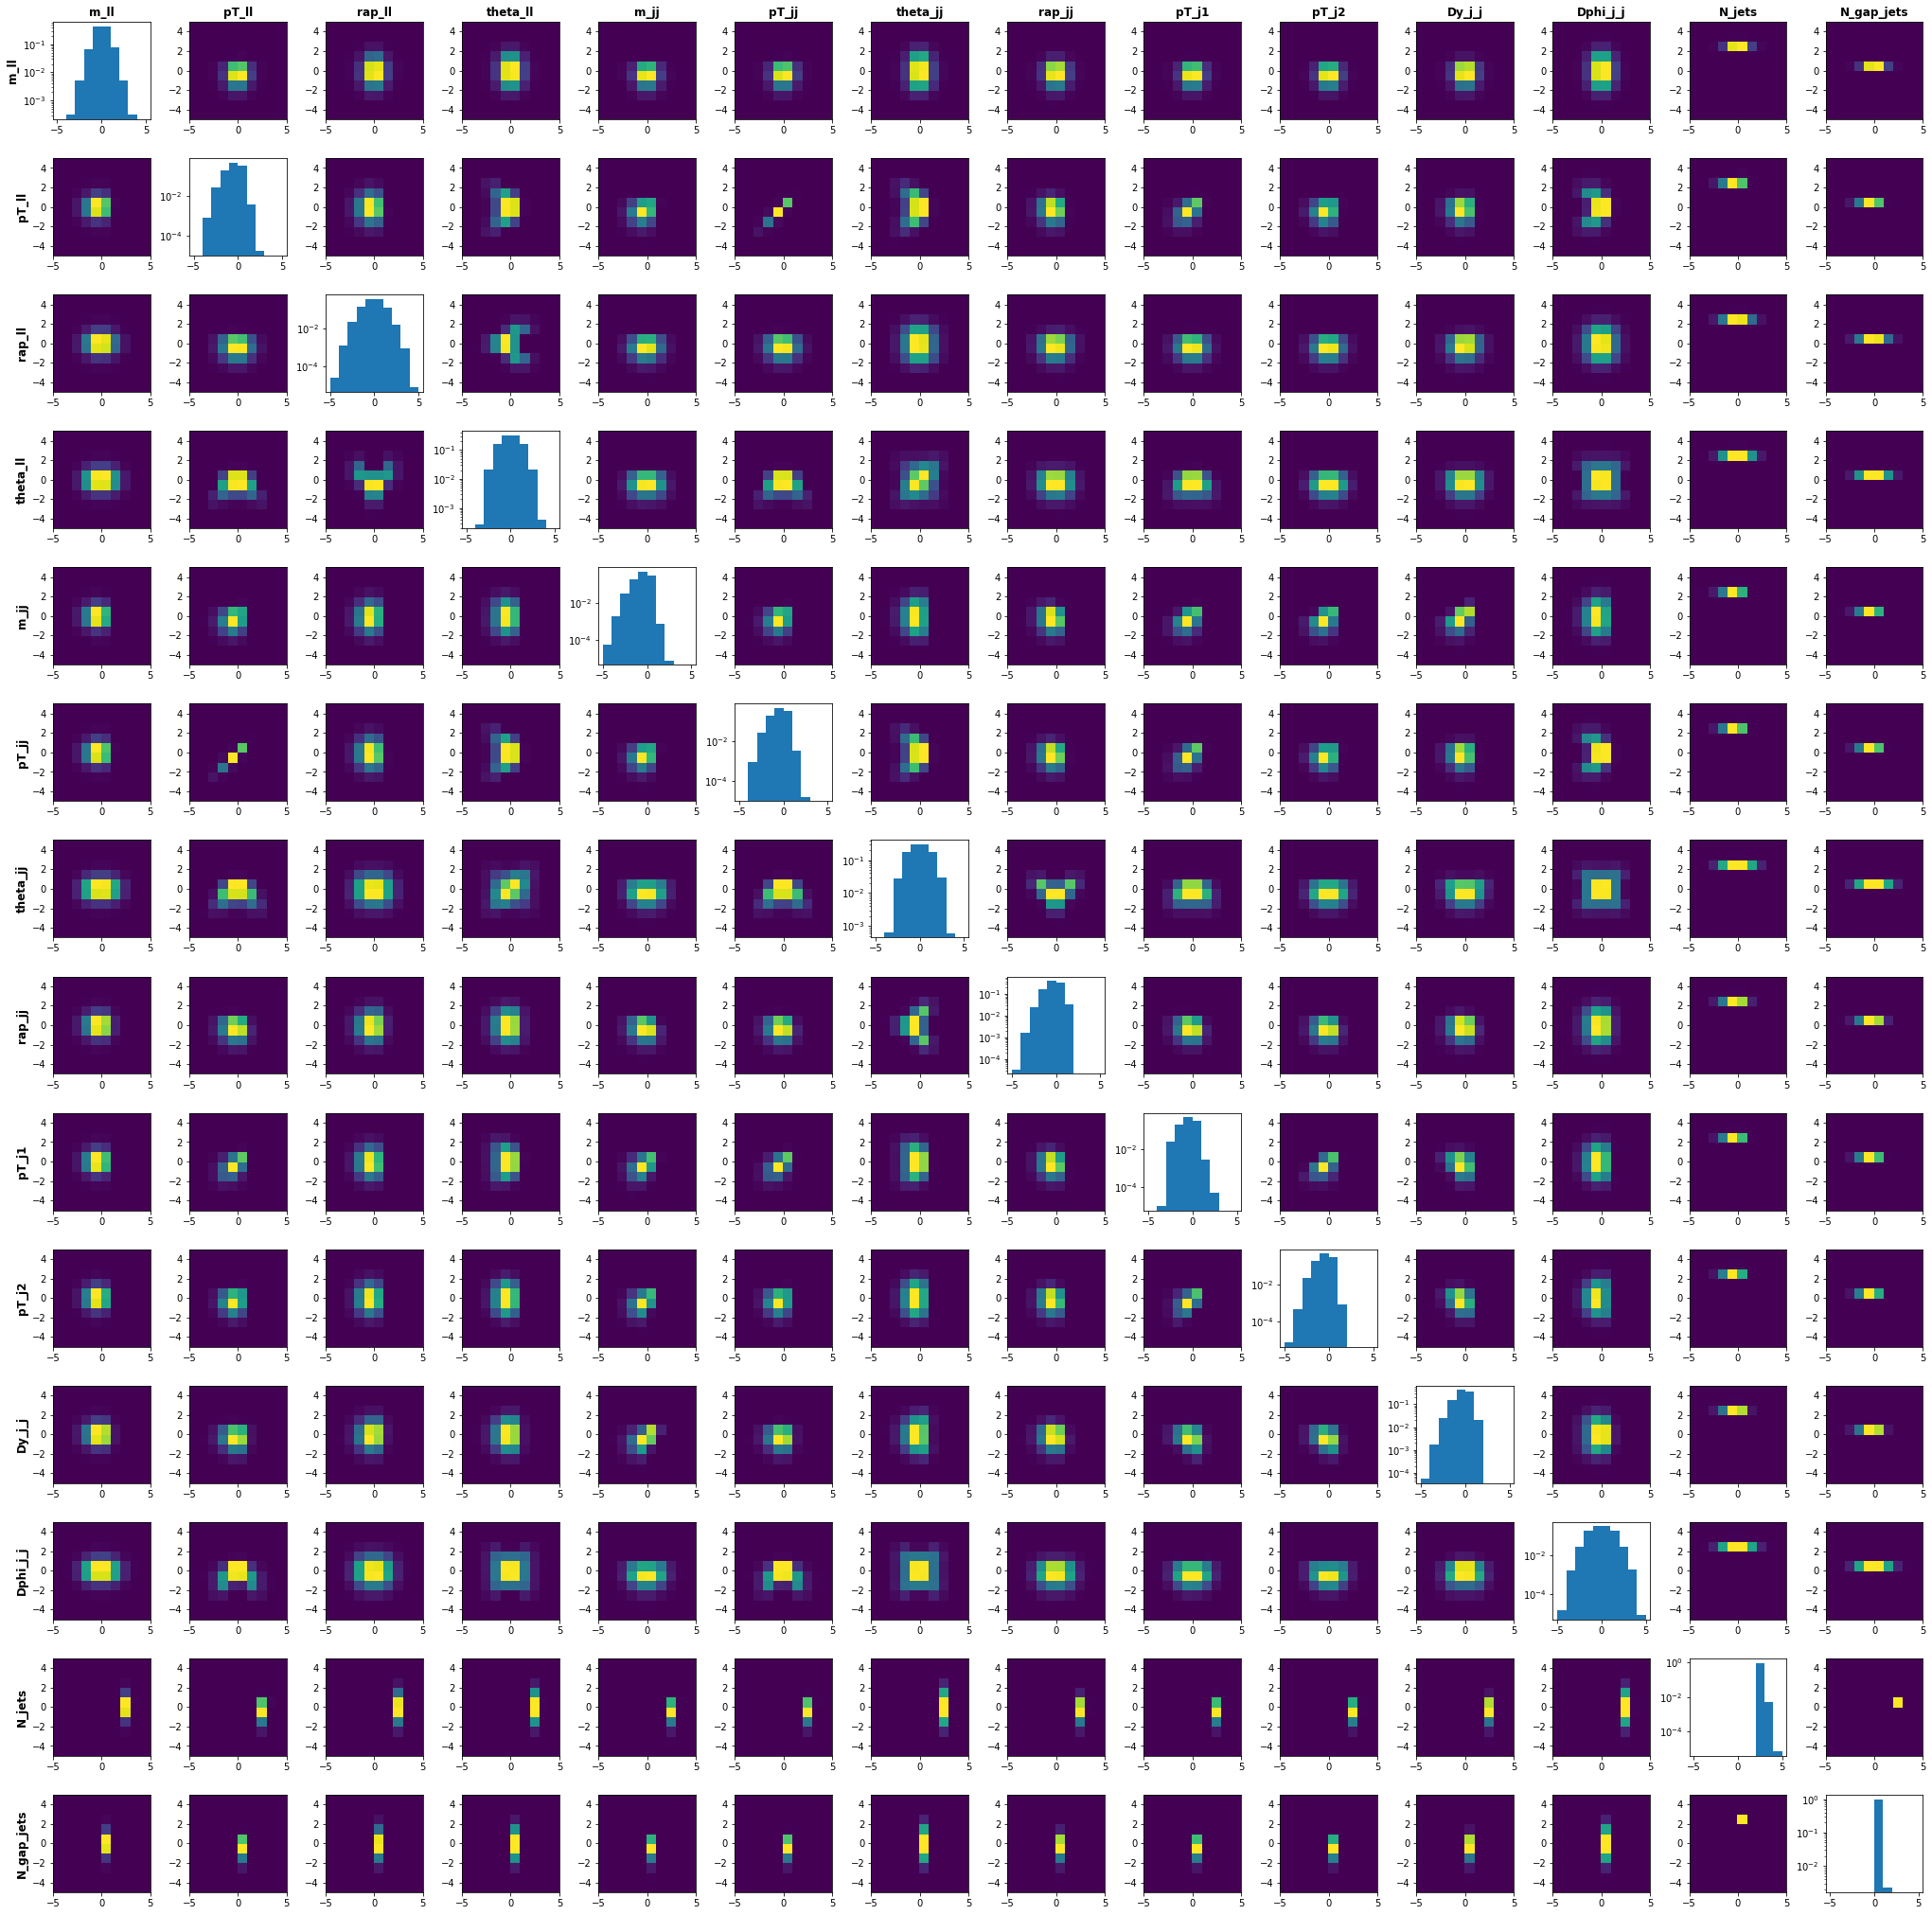

In [6]:
#  Seperate data from weights
observable_data, weight_data = data.get_observables_and_weights()

#  Plot data
#print("Plotting dataset")
#plot_data(observable_data, weight_data, keys=data.keys, bins=15)

#  Whiten data
print("Whitening dataset")
whitening_funcs = None
if type(load_whitening_funcs) != type(None) :
    print(f"Loading whitening functions from file {load_whitening_funcs}")
    whitening_funcs = pickle.load(open(load_whitening_funcs, "rb"))
axis_configs = [[observable_limits[key][0], observable_limits[key][1], whitening_num_points,  white_linear_fraction_data, white_linear_fraction_gauss] for key in data.keys]
white_dataset, whitening_funcs = whiten_axes (observable_data, data.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs)
if type(save_whitening_funcs) != type(None) :
    print(f"Saving whitening functions to file {save_whitening_funcs}")
    pickle.dump(whitening_funcs, open(save_whitening_funcs, "wb"))
    
#  Plot whitened data
print("Plotting whitened dataset")
plot_data(white_dataset, weight_data, keys=data.keys, lims=False, bins=10)


In [7]:
#  Load model if requested, otherwise build and fit

white_data_to_fit = {0: white_dataset}
weights_to_fit = {0: weight_data}

if type(load_model_dir) != type(None) :
    density_model = DensityModel.from_dir(load_model_dir)
else :
    #  Create density model
    density_model = DensityModel(name            = "QCD_density_model", 
                                 num_gaussians   = output_size_per_stage, 
                                 num_conditions  = 1, 
                                 num_observables = data.get_num_observables(), 
                                 types           = data.types,
                                 int_limits      = {idx:observable_limits[obs] for idx,(obs,t) in enumerate(zip(data.keys, data.types)) if t == int},
                                 verbose         = True)
    fit_times = {}
    for obs_idx in range(white_data_to_fit[0].shape[1]) :
        fit_start_time = time.time()
        num_epochs = max_epochs + obs_idx*epoch_increase_per_level
        density_model.fit(white_data_to_fit, 
                          weights_to_fit,
                          observable                = obs_idx,
                          max_epochs_per_observable = num_epochs,
                          early_stopping_patience   = early_stopping_patience,
                          early_stopping_min_delta  = early_stopping_min_delta,
                          validation_split          = validation_split,
                          batch_size_per_observable = batch_size)
        fit_times [obs_idx] = [num_epochs, time.time() - fit_start_time]


INFO       DensityModel.construct      Set model name           : QCD_density_model
INFO       DensityModel.construct      Set model num_gaussians  : 20
INFO       DensityModel.construct      Set model num_conditions : 1
INFO       DensityModel.construct      Set model num_observables: 14
INFO       DensityModel.construct      Set observable types     : [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'int'>, <class 'int'>]
INFO       DensityModel.build          Building model segment: QCD_density_model_observable0 for observable index 0
Creating continuous density model: QCD_density_model_observable0
  - num_conditions_in  is 1
  - num_observables_in is 0
  - num_gaussians      is 20
Instructions for updating:
Colocations handled automatically by placer.
Model: "QCD_density_model_observable0"
________________________________

Model: "QCD_density_model_observable2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 7)            14          input_4[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 6)            18          input_5[0][0]                    
______________________________________________________________________

Model: "QCD_density_model_observable4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 7)            14          input_8[0][0]                    
__________________________________________________________________________________________________
dense_33 (Dense)                (None, 12)           60          input_9[0][0]                    
______________________________________________________________________

Model: "QCD_density_model_observable6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 6)            0                                            
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 7)            14          input_12[0][0]                   
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 18)           126         input_13[0][0]                   
______________________________________________________________________

Model: "QCD_density_model_observable8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 8)            0                                            
__________________________________________________________________________________________________
dense_64 (Dense)                (None, 7)            14          input_16[0][0]                   
__________________________________________________________________________________________________
dense_65 (Dense)                (None, 24)           216         input_17[0][0]                   
______________________________________________________________________

Model: "QCD_density_model_observable10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
dense_80 (Dense)                (None, 7)            14          input_20[0][0]                   
__________________________________________________________________________________________________
dense_81 (Dense)                (None, 30)           330         input_21[0][0]                   
_____________________________________________________________________

INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 500
INFO       DensityModel.fit              -  Training setting: batch_size = 2000
INFO       DensityModel.fit              -  Training setting: validation_split = 0.3
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 10
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 84244 samples, validate on 36105 samples
Epoch 1/500
84244/84244 [==============================] - 3s 33us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 2/500
84244/84244 [==============================] - 0s 5us/step - loss: 9.3642e-04 - val_loss: 8.3500e-04
Epoch 3/500
84244/84244 [==============================] - 0s 5us/step - loss: 7.3736e-04 - val_loss: 6.4561e-04
Epoch 4/500
84244/84244 [==============================] - 0s 5us/step - loss: 5.9655e-04 - val_loss: 5.5787e-04
Epoch 5/500
8424

84244/84244 [==============================] - 0s 5us/step - loss: 5.2166e-04 - val_loss: 5.2026e-04
Epoch 69/500
84244/84244 [==============================] - 0s 5us/step - loss: 5.2164e-04 - val_loss: 5.2020e-04
Epoch 70/500
84244/84244 [==============================] - 0s 5us/step - loss: 5.2167e-04 - val_loss: 5.2026e-04
Epoch 71/500
84244/84244 [==============================] - 0s 5us/step - loss: 5.2163e-04 - val_loss: 5.2019e-04
Epoch 72/500
84244/84244 [==============================] - 0s 5us/step - loss: 5.2167e-04 - val_loss: 5.2044e-04
Epoch 73/500
84244/84244 [==============================] - 0s 5us/step - loss: 5.2170e-04 - val_loss: 5.2023e-04
Epoch 74/500
84244/84244 [==============================] - 0s 5us/step - loss: 5.2166e-04 - val_loss: 5.2027e-04
Epoch 75/500
84244/84244 [==============================] - 0s 5us/step - loss: 5.2168e-04 - val_loss: 5.2019e-04
Epoch 76/500
84244/84244 [==============================] - 0s 5us/step - loss: 5.2167e-04 - val_loss

Epoch 29/520
84244/84244 [==============================] - 0s 5us/step - loss: 5.1350e-04 - val_loss: 5.0951e-04
Epoch 30/520
84244/84244 [==============================] - 0s 5us/step - loss: 5.1340e-04 - val_loss: 5.0931e-04
Epoch 31/520
84244/84244 [==============================] - 0s 6us/step - loss: 5.1346e-04 - val_loss: 5.0931e-04
Epoch 32/520
84244/84244 [==============================] - 0s 6us/step - loss: 5.1355e-04 - val_loss: 5.0928e-04
Epoch 33/520
84244/84244 [==============================] - 0s 5us/step - loss: 5.1354e-04 - val_loss: 5.0928e-04
Epoch 34/520
84244/84244 [==============================] - 0s 5us/step - loss: 5.1350e-04 - val_loss: 5.0932e-04
Epoch 35/520
84244/84244 [==============================] - 0s 5us/step - loss: 5.1341e-04 - val_loss: 5.0937e-04
Epoch 36/520
84244/84244 [==============================] - 0s 5us/step - loss: 5.1341e-04 - val_loss: 5.0929e-04
Epoch 37/520
84244/84244 [==============================] - 0s 5us/step - loss: 5.1340e-

84244/84244 [==============================] - 0s 5us/step - loss: -0.0010 - val_loss: -0.0010
Epoch 13/560
84244/84244 [==============================] - 0s 5us/step - loss: -0.0011 - val_loss: -0.0011
Epoch 14/560
84244/84244 [==============================] - 0s 5us/step - loss: -0.0011 - val_loss: -0.0011
Epoch 15/560
84244/84244 [==============================] - 0s 6us/step - loss: -0.0011 - val_loss: -0.0011
Epoch 16/560
84244/84244 [==============================] - 0s 6us/step - loss: -0.0011 - val_loss: -0.0011
Epoch 17/560
84244/84244 [==============================] - 0s 6us/step - loss: -0.0012 - val_loss: -0.0011
Epoch 18/560
84244/84244 [==============================] - 0s 6us/step - loss: -0.0012 - val_loss: -0.0012
Epoch 19/560
84244/84244 [==============================] - 0s 6us/step - loss: -0.0012 - val_loss: -0.0012
Epoch 20/560
84244/84244 [==============================] - 0s 6us/step - loss: -0.0012 - val_loss: -0.0012
Epoch 21/560
84244/84244 [===============

Train on 84244 samples, validate on 36105 samples
Epoch 1/580
84244/84244 [==============================] - 3s 40us/step - loss: 9.7921e-04 - val_loss: 8.3435e-04
Epoch 2/580
84244/84244 [==============================] - 0s 5us/step - loss: 7.1843e-04 - val_loss: 6.1177e-04
Epoch 3/580
84244/84244 [==============================] - 0s 5us/step - loss: 5.5870e-04 - val_loss: 5.2105e-04
Epoch 4/580
84244/84244 [==============================] - 0s 5us/step - loss: 5.1008e-04 - val_loss: 5.0136e-04
Epoch 5/580
84244/84244 [==============================] - 0s 5us/step - loss: 4.9920e-04 - val_loss: 4.9550e-04
Epoch 6/580
84244/84244 [==============================] - 0s 5us/step - loss: 4.9496e-04 - val_loss: 4.9304e-04
Epoch 7/580
84244/84244 [==============================] - 0s 5us/step - loss: 4.9286e-04 - val_loss: 4.9145e-04
Epoch 8/580
84244/84244 [==============================] - 0s 5us/step - loss: 4.9165e-04 - val_loss: 4.9097e-04
Epoch 9/580
84244/84244 [====================

84244/84244 [==============================] - 4s 42us/step - loss: 8.9920e-04 - val_loss: 6.5181e-04
Epoch 2/600
84244/84244 [==============================] - 0s 6us/step - loss: 3.1662e-04 - val_loss: -9.5706e-06
Epoch 3/600
84244/84244 [==============================] - 0s 5us/step - loss: -2.1259e-04 - val_loss: -3.9145e-04
Epoch 4/600
84244/84244 [==============================] - 0s 5us/step - loss: -5.1204e-04 - val_loss: -6.0059e-04
Epoch 5/600
84244/84244 [==============================] - 0s 6us/step - loss: -6.5883e-04 - val_loss: -7.0442e-04
Epoch 6/600
84244/84244 [==============================] - 0s 5us/step - loss: -7.3056e-04 - val_loss: -7.5136e-04
Epoch 7/600
84244/84244 [==============================] - 0s 5us/step - loss: -7.6207e-04 - val_loss: -7.7450e-04
Epoch 8/600
84244/84244 [==============================] - 0s 6us/step - loss: -7.8155e-04 - val_loss: -7.8838e-04
Epoch 9/600
84244/84244 [==============================] - 0s 5us/step - loss: -7.9382e-04 - v

Epoch 13/620
84244/84244 [==============================] - 0s 5us/step - loss: 5.7317e-04 - val_loss: 5.7432e-04
Epoch 14/620
84244/84244 [==============================] - 0s 5us/step - loss: 5.7262e-04 - val_loss: 5.7396e-04
Epoch 15/620
84244/84244 [==============================] - 0s 5us/step - loss: 5.7211e-04 - val_loss: 5.7344e-04
Epoch 16/620
84244/84244 [==============================] - 0s 6us/step - loss: 5.7184e-04 - val_loss: 5.7379e-04
Epoch 17/620
84244/84244 [==============================] - 0s 6us/step - loss: 5.7150e-04 - val_loss: 5.7287e-04
Epoch 18/620
84244/84244 [==============================] - 0s 6us/step - loss: 5.7120e-04 - val_loss: 5.7287e-04
Epoch 19/620
84244/84244 [==============================] - 0s 6us/step - loss: 5.7137e-04 - val_loss: 5.7301e-04
Epoch 20/620
84244/84244 [==============================] - 0s 6us/step - loss: 5.7088e-04 - val_loss: 5.7281e-04
Epoch 21/620
84244/84244 [==============================] - 1s 6us/step - loss: 5.7056e-

84244/84244 [==============================] - 1s 6us/step - loss: -8.9487e-04 - val_loss: -8.8960e-04
Epoch 23/640
84244/84244 [==============================] - 1s 6us/step - loss: -9.1422e-04 - val_loss: -9.2162e-04
Epoch 24/640
84244/84244 [==============================] - 0s 6us/step - loss: -9.2647e-04 - val_loss: -8.5095e-04
Epoch 25/640
84244/84244 [==============================] - 0s 6us/step - loss: -9.2743e-04 - val_loss: -9.0844e-04
Epoch 26/640
84244/84244 [==============================] - 0s 6us/step - loss: -9.4371e-04 - val_loss: -9.3198e-04
Epoch 27/640
84244/84244 [==============================] - 0s 6us/step - loss: -9.5602e-04 - val_loss: -9.4373e-04
Epoch 28/640
84244/84244 [==============================] - 0s 6us/step - loss: -9.6283e-04 - val_loss: -9.6698e-04
Epoch 29/640
84244/84244 [==============================] - 0s 6us/step - loss: -9.7171e-04 - val_loss: -9.8073e-04
Epoch 30/640
84244/84244 [==============================] - 0s 6us/step - loss: -9.91

84244/84244 [==============================] - 0s 6us/step - loss: -0.0013 - val_loss: -0.0012
Epoch 98/640
84244/84244 [==============================] - 0s 6us/step - loss: -0.0013 - val_loss: -0.0013
Epoch 99/640
84244/84244 [==============================] - 1s 6us/step - loss: -0.0012 - val_loss: -0.0012
Epoch 100/640
84244/84244 [==============================] - 0s 6us/step - loss: -0.0012 - val_loss: -0.0012
Epoch 101/640
84244/84244 [==============================] - 0s 6us/step - loss: -0.0013 - val_loss: -0.0012
Epoch 102/640
84244/84244 [==============================] - 0s 6us/step - loss: -0.0013 - val_loss: -0.0013
Epoch 103/640
84244/84244 [==============================] - 0s 6us/step - loss: -0.0013 - val_loss: -0.0013
Epoch 104/640
84244/84244 [==============================] - 0s 6us/step - loss: -0.0013 - val_loss: -0.0013
Epoch 105/640
84244/84244 [==============================] - 0s 6us/step - loss: -0.0013 - val_loss: -0.0013
Epoch 106/640
84244/84244 [========

84244/84244 [==============================] - 1s 6us/step - loss: -0.0014 - val_loss: -0.0013
Epoch 173/640
84244/84244 [==============================] - 1s 6us/step - loss: -0.0014 - val_loss: -0.0014
Epoch 174/640
84244/84244 [==============================] - 0s 6us/step - loss: -0.0014 - val_loss: -0.0013
Epoch 175/640
84244/84244 [==============================] - 0s 6us/step - loss: -0.0014 - val_loss: -0.0014
Epoch 176/640
84244/84244 [==============================] - 1s 6us/step - loss: -0.0014 - val_loss: -0.0014
Epoch 177/640
84244/84244 [==============================] - 1s 6us/step - loss: -0.0014 - val_loss: -0.0013
Epoch 178/640
84244/84244 [==============================] - 1s 6us/step - loss: -0.0014 - val_loss: -0.0014
Epoch 179/640
84244/84244 [==============================] - 1s 6us/step - loss: -0.0014 - val_loss: -0.0014
Epoch 180/640
84244/84244 [==============================] - 1s 6us/step - loss: -0.0014 - val_loss: -0.0014
Epoch 181/640
84244/84244 [======

84244/84244 [==============================] - 0s 6us/step - loss: 2.3684e-04 - val_loss: 2.3872e-04
Epoch 48/660
84244/84244 [==============================] - 0s 6us/step - loss: 2.3617e-04 - val_loss: 2.3830e-04
Epoch 49/660
84244/84244 [==============================] - 0s 6us/step - loss: 2.3618e-04 - val_loss: 2.3949e-04
Epoch 50/660
84244/84244 [==============================] - 0s 6us/step - loss: 2.3569e-04 - val_loss: 2.3891e-04
Epoch 51/660
84244/84244 [==============================] - 0s 6us/step - loss: 2.3522e-04 - val_loss: 2.3756e-04
Epoch 52/660
84244/84244 [==============================] - 0s 6us/step - loss: 2.3482e-04 - val_loss: 2.3705e-04
Epoch 53/660
84244/84244 [==============================] - 0s 6us/step - loss: 2.3455e-04 - val_loss: 2.3720e-04
Epoch 54/660
84244/84244 [==============================] - 0s 6us/step - loss: 2.3392e-04 - val_loss: 2.3684e-04
Epoch 55/660
84244/84244 [==============================] - 0s 6us/step - loss: 2.3386e-04 - val_loss

Epoch 119/660
84244/84244 [==============================] - 1s 6us/step - loss: 2.2445e-04 - val_loss: 2.2833e-04
Epoch 120/660
84244/84244 [==============================] - 1s 6us/step - loss: 2.2377e-04 - val_loss: 2.2804e-04
Epoch 121/660
84244/84244 [==============================] - 1s 6us/step - loss: 2.2349e-04 - val_loss: 2.2723e-04
Epoch 122/660
84244/84244 [==============================] - 1s 6us/step - loss: 2.2347e-04 - val_loss: 2.2855e-04
Epoch 123/660
84244/84244 [==============================] - 1s 6us/step - loss: 2.2373e-04 - val_loss: 2.2785e-04
Epoch 124/660
84244/84244 [==============================] - 1s 6us/step - loss: 2.2413e-04 - val_loss: 2.2771e-04
Epoch 125/660
84244/84244 [==============================] - 1s 6us/step - loss: 2.2345e-04 - val_loss: 2.2826e-04
Epoch 126/660
84244/84244 [==============================] - 1s 6us/step - loss: 2.2312e-04 - val_loss: 2.2769e-04
Epoch 127/660
84244/84244 [==============================] - 1s 6us/step - loss:

84244/84244 [==============================] - 1s 6us/step - loss: 1.0174e-04 - val_loss: 1.0537e-04
Epoch 18/680
84244/84244 [==============================] - 1s 6us/step - loss: 9.6682e-05 - val_loss: 1.0033e-04
Epoch 19/680
84244/84244 [==============================] - 1s 6us/step - loss: 9.2772e-05 - val_loss: 9.8758e-05
Epoch 20/680
84244/84244 [==============================] - 1s 6us/step - loss: 9.0276e-05 - val_loss: 9.7469e-05
Epoch 21/680
84244/84244 [==============================] - 1s 6us/step - loss: 8.7038e-05 - val_loss: 8.8683e-05
Epoch 22/680
84244/84244 [==============================] - 1s 6us/step - loss: 8.5788e-05 - val_loss: 8.4306e-05
Epoch 23/680
84244/84244 [==============================] - 1s 6us/step - loss: 8.0858e-05 - val_loss: 9.3614e-05
Epoch 24/680
84244/84244 [==============================] - 0s 6us/step - loss: 7.8787e-05 - val_loss: 7.8953e-05
Epoch 25/680
84244/84244 [==============================] - 0s 6us/step - loss: 7.5989e-05 - val_loss

Epoch 89/680
84244/84244 [==============================] - 1s 6us/step - loss: 1.7580e-05 - val_loss: 2.2248e-05
Epoch 90/680
84244/84244 [==============================] - 1s 6us/step - loss: 1.5687e-05 - val_loss: 2.1828e-05
Epoch 91/680
84244/84244 [==============================] - 1s 6us/step - loss: 1.5488e-05 - val_loss: 2.2910e-05
Epoch 92/680
84244/84244 [==============================] - 1s 6us/step - loss: 1.7648e-05 - val_loss: 2.2945e-05
Epoch 93/680
84244/84244 [==============================] - 1s 6us/step - loss: 2.2464e-05 - val_loss: 2.5220e-05
Epoch 94/680
84244/84244 [==============================] - 1s 6us/step - loss: 1.5687e-05 - val_loss: 2.2484e-05
Epoch 95/680
84244/84244 [==============================] - 1s 6us/step - loss: 1.4137e-05 - val_loss: 2.6097e-05
Epoch 96/680
84244/84244 [==============================] - 1s 6us/step - loss: 1.4190e-05 - val_loss: 2.1803e-05
Epoch 97/680
84244/84244 [==============================] - 1s 6us/step - loss: 1.4302e-

84244/84244 [==============================] - 1s 6us/step - loss: -6.6155e-06 - val_loss: 4.7805e-08
Epoch 161/680
84244/84244 [==============================] - 1s 6us/step - loss: -6.8297e-06 - val_loss: 3.7536e-07
Epoch 162/680
84244/84244 [==============================] - 1s 6us/step - loss: -6.1640e-06 - val_loss: 7.5253e-07
Epoch 163/680
84244/84244 [==============================] - 1s 6us/step - loss: -6.3175e-06 - val_loss: 9.9379e-07
Epoch 164/680
84244/84244 [==============================] - 1s 6us/step - loss: -7.6188e-06 - val_loss: -2.4291e-06
Epoch 165/680
84244/84244 [==============================] - 1s 6us/step - loss: -8.3542e-06 - val_loss: 7.4255e-06
Epoch 166/680
84244/84244 [==============================] - 1s 6us/step - loss: -6.8408e-06 - val_loss: 8.5354e-07
Epoch 167/680
84244/84244 [==============================] - 1s 7us/step - loss: -7.7211e-06 - val_loss: -5.3046e-07
Epoch 168/680
84244/84244 [==============================] - 1s 7us/step - loss: -9.

84244/84244 [==============================] - 1s 6us/step - loss: -2.8287e-05 - val_loss: -2.5422e-05
Epoch 231/680
84244/84244 [==============================] - 1s 6us/step - loss: -3.3313e-05 - val_loss: -2.2939e-05
Epoch 232/680
84244/84244 [==============================] - 1s 6us/step - loss: -3.3145e-05 - val_loss: -2.6060e-05
Epoch 233/680
84244/84244 [==============================] - 1s 6us/step - loss: -3.3711e-05 - val_loss: -2.1185e-05
Epoch 234/680
84244/84244 [==============================] - 1s 6us/step - loss: -3.2077e-05 - val_loss: -2.6979e-05
Epoch 235/680
84244/84244 [==============================] - 1s 6us/step - loss: -3.3493e-05 - val_loss: -2.3568e-05
Epoch 236/680
84244/84244 [==============================] - 1s 6us/step - loss: -3.3972e-05 - val_loss: -2.9111e-05
Epoch 237/680
84244/84244 [==============================] - 1s 6us/step - loss: -3.3948e-05 - val_loss: -2.7826e-05
Epoch 238/680
84244/84244 [==============================] - 1s 6us/step - los

84244/84244 [==============================] - 1s 7us/step - loss: -9.2668e-04 - val_loss: -8.7579e-04
Epoch 46/700
84244/84244 [==============================] - 1s 7us/step - loss: -9.0119e-04 - val_loss: -9.3963e-04
Epoch 47/700
84244/84244 [==============================] - 1s 7us/step - loss: -9.2748e-04 - val_loss: -9.1885e-04
Epoch 48/700
84244/84244 [==============================] - 1s 7us/step - loss: -9.4051e-04 - val_loss: -9.4963e-04
Epoch 49/700
84244/84244 [==============================] - 1s 7us/step - loss: -9.4241e-04 - val_loss: -9.4883e-04
Epoch 50/700
84244/84244 [==============================] - 1s 7us/step - loss: -9.4176e-04 - val_loss: -9.2903e-04
Epoch 51/700
84244/84244 [==============================] - 1s 7us/step - loss: -9.4955e-04 - val_loss: -9.6376e-04
Epoch 52/700
84244/84244 [==============================] - 1s 7us/step - loss: -9.5307e-04 - val_loss: -9.4340e-04
Epoch 53/700
84244/84244 [==============================] - 1s 7us/step - loss: -9.55

84244/84244 [==============================] - 1s 7us/step - loss: -0.0012 - val_loss: -0.0011
Epoch 120/700
84244/84244 [==============================] - 1s 7us/step - loss: -0.0012 - val_loss: -0.0011
Epoch 121/700
84244/84244 [==============================] - 1s 7us/step - loss: -0.0011 - val_loss: -0.0010
Epoch 122/700
84244/84244 [==============================] - 1s 7us/step - loss: -0.0012 - val_loss: -0.0011
Epoch 123/700
84244/84244 [==============================] - 1s 7us/step - loss: -0.0012 - val_loss: -0.0011
Epoch 124/700
84244/84244 [==============================] - 1s 7us/step - loss: -0.0012 - val_loss: -0.0012
Epoch 125/700
84244/84244 [==============================] - 1s 7us/step - loss: -0.0012 - val_loss: -0.0011
Epoch 126/700
84244/84244 [==============================] - 1s 7us/step - loss: -0.0012 - val_loss: -0.0012
Epoch 127/700
84244/84244 [==============================] - 1s 7us/step - loss: -0.0012 - val_loss: -0.0011
Epoch 128/700
84244/84244 [======

84244/84244 [==============================] - 1s 7us/step - loss: -5.8079e-04 - val_loss: -5.9320e-04
Epoch 43/720
84244/84244 [==============================] - 1s 7us/step - loss: -5.8046e-04 - val_loss: -5.9213e-04
Epoch 44/720
84244/84244 [==============================] - 1s 7us/step - loss: -6.0010e-04 - val_loss: -5.8543e-04
Epoch 45/720
84244/84244 [==============================] - 1s 7us/step - loss: -6.0993e-04 - val_loss: -5.7291e-04
Epoch 46/720
84244/84244 [==============================] - 1s 7us/step - loss: -5.9923e-04 - val_loss: -5.8635e-04
Epoch 47/720
84244/84244 [==============================] - 1s 7us/step - loss: -6.1892e-04 - val_loss: -5.9263e-04
Epoch 48/720
84244/84244 [==============================] - 1s 7us/step - loss: -6.3262e-04 - val_loss: -6.2400e-04
Epoch 49/720
84244/84244 [==============================] - 1s 7us/step - loss: -6.3989e-04 - val_loss: -5.9373e-04
Epoch 50/720
84244/84244 [==============================] - 1s 7us/step - loss: -6.20

84244/84244 [==============================] - 1s 7us/step - loss: -8.4527e-04 - val_loss: -7.2890e-04
Epoch 113/720
84244/84244 [==============================] - 1s 7us/step - loss: -8.4460e-04 - val_loss: -8.5756e-04
Epoch 114/720
84244/84244 [==============================] - 1s 7us/step - loss: -7.9530e-04 - val_loss: -8.0855e-04
Epoch 115/720
84244/84244 [==============================] - 1s 7us/step - loss: -8.4830e-04 - val_loss: -8.2594e-04
Epoch 116/720
84244/84244 [==============================] - 1s 7us/step - loss: -8.6289e-04 - val_loss: -8.1171e-04
Epoch 117/720
84244/84244 [==============================] - 1s 7us/step - loss: -8.4384e-04 - val_loss: -8.4123e-04
Epoch 118/720
84244/84244 [==============================] - 1s 7us/step - loss: -8.6952e-04 - val_loss: -8.5729e-04
Epoch 119/720
84244/84244 [==============================] - 1s 7us/step - loss: -8.4031e-04 - val_loss: -8.1018e-04
Epoch 120/720
84244/84244 [==============================] - 1s 7us/step - los

84244/84244 [==============================] - 0s 2us/step - loss: 1.6384e-05 - val_loss: 1.6761e-05
Epoch 19/740
84244/84244 [==============================] - 0s 2us/step - loss: 1.6304e-05 - val_loss: 1.6698e-05
Epoch 20/740
84244/84244 [==============================] - 0s 2us/step - loss: 1.6241e-05 - val_loss: 1.6640e-05
Epoch 21/740
84244/84244 [==============================] - 0s 2us/step - loss: 1.6183e-05 - val_loss: 1.6582e-05
Epoch 22/740
84244/84244 [==============================] - 0s 2us/step - loss: 1.6128e-05 - val_loss: 1.6534e-05
Epoch 23/740
84244/84244 [==============================] - 0s 2us/step - loss: 1.6082e-05 - val_loss: 1.6488e-05
Epoch 24/740
84244/84244 [==============================] - 0s 2us/step - loss: 1.6042e-05 - val_loss: 1.6454e-05
Epoch 25/740
84244/84244 [==============================] - 0s 2us/step - loss: 1.6003e-05 - val_loss: 1.6419e-05
Epoch 26/740
84244/84244 [==============================] - 0s 2us/step - loss: 1.5967e-05 - val_loss

Epoch 90/740
84244/84244 [==============================] - 0s 2us/step - loss: 1.5103e-05 - val_loss: 1.5799e-05
Epoch 91/740
84244/84244 [==============================] - 0s 2us/step - loss: 1.5051e-05 - val_loss: 1.5781e-05
Epoch 92/740
84244/84244 [==============================] - 0s 2us/step - loss: 1.5048e-05 - val_loss: 1.5761e-05
Epoch 93/740
84244/84244 [==============================] - 0s 2us/step - loss: 1.5059e-05 - val_loss: 1.5749e-05
Epoch 94/740
84244/84244 [==============================] - 0s 2us/step - loss: 1.5029e-05 - val_loss: 1.5757e-05
Epoch 95/740
84244/84244 [==============================] - 0s 2us/step - loss: 1.5023e-05 - val_loss: 1.5750e-05
Epoch 96/740
84244/84244 [==============================] - 0s 2us/step - loss: 1.5028e-05 - val_loss: 1.5747e-05
Epoch 97/740
84244/84244 [==============================] - 0s 2us/step - loss: 1.5014e-05 - val_loss: 1.5761e-05
Epoch 98/740
84244/84244 [==============================] - 0s 2us/step - loss: 1.4985e-

84244/84244 [==============================] - 0s 2us/step - loss: 9.2820e-06 - val_loss: 9.8260e-06
Epoch 26/760
84244/84244 [==============================] - 0s 2us/step - loss: 9.1980e-06 - val_loss: 9.7449e-06
Epoch 27/760
84244/84244 [==============================] - 0s 2us/step - loss: 9.1192e-06 - val_loss: 9.6637e-06
Epoch 28/760
84244/84244 [==============================] - 0s 2us/step - loss: 9.0435e-06 - val_loss: 9.5816e-06
Epoch 29/760
84244/84244 [==============================] - 0s 2us/step - loss: 8.9747e-06 - val_loss: 9.4974e-06
Epoch 30/760
84244/84244 [==============================] - 0s 2us/step - loss: 8.9081e-06 - val_loss: 9.4272e-06
Epoch 31/760
84244/84244 [==============================] - 0s 2us/step - loss: 8.8394e-06 - val_loss: 9.3665e-06
Epoch 32/760
84244/84244 [==============================] - 0s 2us/step - loss: 8.7774e-06 - val_loss: 9.2986e-06
Epoch 33/760
84244/84244 [==============================] - 0s 2us/step - loss: 8.7181e-06 - val_loss

Epoch 97/760
84244/84244 [==============================] - 0s 2us/step - loss: 1.0069e-06 - val_loss: 1.1583e-06
Epoch 98/760
84244/84244 [==============================] - 0s 2us/step - loss: 9.8135e-07 - val_loss: 1.1726e-06
Epoch 99/760
84244/84244 [==============================] - 0s 2us/step - loss: 9.5583e-07 - val_loss: 1.1096e-06
Epoch 100/760
84244/84244 [==============================] - 0s 2us/step - loss: 1.0078e-06 - val_loss: 1.2616e-06
Epoch 101/760
84244/84244 [==============================] - 0s 2us/step - loss: 9.5853e-07 - val_loss: 1.1076e-06
Epoch 102/760
84244/84244 [==============================] - 0s 2us/step - loss: 9.5721e-07 - val_loss: 1.1009e-06
Epoch 103/760
84244/84244 [==============================] - 0s 2us/step - loss: 9.5097e-07 - val_loss: 1.1131e-06
Epoch 104/760
84244/84244 [==============================] - 0s 2us/step - loss: 9.3505e-07 - val_loss: 1.1405e-06
Epoch 105/760
84244/84244 [==============================] - 0s 2us/step - loss: 9.

In [17]:
#  Use this cell to add training epochs to whichever indices appear undertrained

improve_indices    = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
impove_num_epochs  = 1000
improve_patience   = 20
improve_batch_size = -1
improve_validation_split = 0

added_fit_times = {}
for obs_idx in improve_indices :
    fit_start_time = time.time()
    density_model.fit(white_data_to_fit, 
                      weights_to_fit,
                      observable                = obs_idx,
                      max_epochs_per_observable = impove_num_epochs,
                      early_stopping_patience   = improve_patience,
                      validation_split          = improve_validation_split,
                      batch_size_per_observable = improve_batch_size)
    added_fit_times [obs_idx] = [impove_num_epochs, time.time() - fit_start_time]
    

INFO       DensityModel.fit            Queued the following observable indices to train: 0
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 1000
INFO       DensityModel.fit              -  Training setting: batch_size = -1
INFO       DensityModel.fit              -  Training setting: validation_split = 0
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 20
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
INFO       DensityModel.fit            Setting batch size to size of dataset, which is 120349
Epoch 1/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2114e-04
Epoch 2/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2114e-04
Epoch 3/1000
120349/120349 [==============================] - 0s 4us/step - loss: 

Epoch 81/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2114e-04
Epoch 82/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2114e-04
Epoch 83/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2114e-04
Epoch 84/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2114e-04
Epoch 85/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2114e-04
Epoch 86/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2114e-04
Epoch 87/1000
120349/120349 [==============================] - 1s 5us/step - loss: 5.2114e-04
Epoch 88/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2114e-04
Epoch 89/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2114e-04
Epoch 90/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2114e-04
Epoch 91/1000
120349/120349 [==============================]

Epoch 168/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2114e-04
Epoch 169/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2114e-04
Epoch 170/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2114e-04
Epoch 171/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2114e-04
Epoch 172/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2114e-04
Epoch 173/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2114e-04
Epoch 174/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2114e-04
Epoch 175/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2114e-04
Epoch 176/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2114e-04
Epoch 177/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2114e-04
Epoch 178/1000
120349/120349 [====================

Epoch 255/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 256/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 257/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 258/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 259/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 260/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 261/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 262/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 263/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 264/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 265/1000
120349/120349 [====================

Epoch 342/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 343/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 344/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 345/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 346/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 347/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 348/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 349/1000
120349/120349 [==============================] - 1s 5us/step - loss: 5.2113e-04
Epoch 350/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 351/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 352/1000
120349/120349 [====================

Epoch 429/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 430/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 431/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 432/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 433/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 434/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 435/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 436/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 437/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 438/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 439/1000
120349/120349 [====================

Epoch 516/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 517/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 518/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 519/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 520/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 521/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 522/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 523/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 524/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 525/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 526/1000
120349/120349 [====================

Epoch 603/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 604/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 605/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 606/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 607/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 608/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 609/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 610/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 611/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 612/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 613/1000
120349/120349 [====================

Epoch 690/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 691/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 692/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 693/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 694/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 695/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 696/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 697/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 698/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 699/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 700/1000
120349/120349 [====================

Epoch 777/1000
120349/120349 [==============================] - 1s 5us/step - loss: 5.2113e-04
Epoch 778/1000
120349/120349 [==============================] - 1s 5us/step - loss: 5.2113e-04
Epoch 779/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 780/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 781/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 782/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 783/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 784/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 785/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 786/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 787/1000
120349/120349 [====================

Epoch 864/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 865/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 866/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 867/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 868/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 869/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 870/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 871/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 872/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 873/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 874/1000
120349/120349 [====================

Epoch 951/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 952/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 953/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 954/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 955/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 956/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 957/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 958/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 959/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.2113e-04
Epoch 960/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.2113e-04
Epoch 961/1000
120349/120349 [====================

Epoch 43/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1197e-04
Epoch 44/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1197e-04
Epoch 45/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1197e-04
Epoch 46/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1197e-04
Epoch 47/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1196e-04
Epoch 48/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1196e-04
Epoch 49/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1196e-04
Epoch 50/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1196e-04
Epoch 51/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1196e-04
Epoch 52/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1196e-04
Epoch 53/1000
120349/120349 [==============================]

Epoch 130/1000
120349/120349 [==============================] - 1s 5us/step - loss: 5.1192e-04
Epoch 131/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1192e-04
Epoch 132/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1192e-04
Epoch 133/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1192e-04
Epoch 134/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1192e-04
Epoch 135/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1192e-04
Epoch 136/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1192e-04
Epoch 137/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1192e-04
Epoch 138/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1192e-04
Epoch 139/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1192e-04
Epoch 140/1000
120349/120349 [====================

Epoch 217/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.1190e-04
Epoch 218/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1190e-04
Epoch 219/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1190e-04
Epoch 220/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1190e-04
Epoch 221/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1190e-04
Epoch 222/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.1190e-04
Epoch 223/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.1190e-04
Epoch 224/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1190e-04
Epoch 225/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1190e-04
Epoch 226/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1190e-04
Epoch 227/1000
120349/120349 [====================

Epoch 304/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1188e-04
Epoch 305/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1188e-04
Epoch 306/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1188e-04
Epoch 307/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1188e-04
Epoch 308/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1188e-04
Epoch 309/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.1188e-04
Epoch 310/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1188e-04
Epoch 311/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.1188e-04
Epoch 312/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.1188e-04
Epoch 313/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.1188e-04
Epoch 314/1000
120349/120349 [====================

Epoch 391/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1186e-04
Epoch 392/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1186e-04
Epoch 393/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1186e-04
Epoch 394/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1186e-04
Epoch 395/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1186e-04
Epoch 396/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1186e-04
Epoch 397/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1186e-04
Epoch 398/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1186e-04
Epoch 399/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1186e-04
Epoch 400/1000
120349/120349 [==============================] - 1s 5us/step - loss: 5.1186e-04
Epoch 401/1000
120349/120349 [====================

Epoch 478/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1185e-04
Epoch 479/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1185e-04
Epoch 480/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1185e-04
Epoch 481/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1185e-04
Epoch 482/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1185e-04
Epoch 483/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1185e-04
Epoch 484/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1185e-04
Epoch 485/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1185e-04
Epoch 486/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1185e-04
Epoch 487/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1185e-04
Epoch 488/1000
120349/120349 [====================

Epoch 565/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1184e-04
Epoch 566/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1184e-04
Epoch 567/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1184e-04
Epoch 568/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1184e-04
Epoch 569/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1184e-04
Epoch 570/1000
120349/120349 [==============================] - 1s 5us/step - loss: 5.1184e-04
Epoch 571/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1184e-04
Epoch 572/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1184e-04
Epoch 573/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1184e-04
Epoch 574/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1184e-04
Epoch 575/1000
120349/120349 [====================

Epoch 652/1000
120349/120349 [==============================] - 1s 5us/step - loss: 5.1183e-04
Epoch 653/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1183e-04
Epoch 654/1000
120349/120349 [==============================] - 1s 5us/step - loss: 5.1183e-04
Epoch 655/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1183e-04
Epoch 656/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1183e-04
Epoch 657/1000
120349/120349 [==============================] - 1s 5us/step - loss: 5.1183e-04
Epoch 658/1000
120349/120349 [==============================] - 1s 5us/step - loss: 5.1183e-04
Epoch 659/1000
120349/120349 [==============================] - 1s 5us/step - loss: 5.1183e-04
Epoch 660/1000
120349/120349 [==============================] - 1s 5us/step - loss: 5.1183e-04
Epoch 661/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1183e-04
Epoch 662/1000
120349/120349 [====================

Epoch 739/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1182e-04
Epoch 740/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1182e-04
Epoch 741/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1182e-04
Epoch 742/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1182e-04
Epoch 743/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1182e-04
Epoch 744/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1182e-04
Epoch 745/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1182e-04
Epoch 746/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1182e-04
Epoch 747/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1182e-04
Epoch 748/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1182e-04
Epoch 749/1000
120349/120349 [====================

Epoch 826/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1182e-04
Epoch 827/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1182e-04
Epoch 828/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1182e-04
Epoch 829/1000
120349/120349 [==============================] - 1s 5us/step - loss: 5.1182e-04
Epoch 830/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1182e-04
Epoch 831/1000
120349/120349 [==============================] - 1s 5us/step - loss: 5.1182e-04
Epoch 832/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1182e-04
Epoch 833/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1182e-04
Epoch 834/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1182e-04
Epoch 835/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1182e-04
Epoch 836/1000
120349/120349 [====================

Epoch 913/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1181e-04
Epoch 914/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1181e-04
Epoch 915/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1181e-04
Epoch 916/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1181e-04
Epoch 917/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1181e-04
Epoch 918/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1181e-04
Epoch 919/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.1181e-04
Epoch 920/1000
120349/120349 [==============================] - 1s 5us/step - loss: 5.1181e-04
Epoch 921/1000
120349/120349 [==============================] - 1s 5us/step - loss: 5.1181e-04
Epoch 922/1000
120349/120349 [==============================] - 1s 5us/step - loss: 5.1181e-04
Epoch 923/1000
120349/120349 [====================

Epoch 1000/1000
120349/120349 [==============================] - 1s 5us/step - loss: 5.1180e-04
Fit completed in 532s
INFO       DensityModel.fit            Queued the following observable indices to train: 2
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 2
INFO       DensityModel.fit              -  Training setting: epochs = 1000
INFO       DensityModel.fit              -  Training setting: batch_size = -1
INFO       DensityModel.fit              -  Training setting: validation_split = 0
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 20
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
INFO       DensityModel.fit            Setting batch size to size of dataset, which is 120349
Epoch 1/1000
120349/120349 [==============================] - 1s 5us/step - loss: 6.6113e-04
Epoch 2/1000
120349/120349 [=============================

Epoch 52/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0015
Epoch 53/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0015
Epoch 54/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0015
Epoch 55/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0015
Epoch 56/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0015
Epoch 57/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0015
Epoch 58/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0015
Epoch 59/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0015
Epoch 60/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0015
Epoch 61/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0015
Epoch 62/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0015

Epoch 142/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0015
Epoch 143/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0015
Epoch 144/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0015
Epoch 145/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0015
Epoch 146/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0015
Fit completed in 79s
INFO       DensityModel.fit            Queued the following observable indices to train: 4
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 4
INFO       DensityModel.fit              -  Training setting: epochs = 1000
INFO       DensityModel.fit              -  Training setting: batch_size = -1
INFO       DensityModel.fit              -  Training setting: validation_split = 0
INFO       DensityModel.fit              -  Training setting: e

Epoch 76/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8720e-04
Epoch 77/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8720e-04
Epoch 78/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8720e-04
Epoch 79/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8720e-04
Epoch 80/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8720e-04
Epoch 81/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8720e-04
Epoch 82/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8720e-04
Epoch 83/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8720e-04
Epoch 84/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8720e-04
Epoch 85/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8719e-04
Epoch 86/1000
120349/120349 [==============================]

Epoch 163/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8715e-04
Epoch 164/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8715e-04
Epoch 165/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8715e-04
Epoch 166/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8715e-04
Epoch 167/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8715e-04
Epoch 168/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8715e-04
Epoch 169/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8714e-04
Epoch 170/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8714e-04
Epoch 171/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8714e-04
Epoch 172/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8714e-04
Epoch 173/1000
120349/120349 [====================

Epoch 250/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8711e-04
Epoch 251/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8711e-04
Epoch 252/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8711e-04
Epoch 253/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8711e-04
Epoch 254/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8711e-04
Epoch 255/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8711e-04
Epoch 256/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8711e-04
Epoch 257/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8711e-04
Epoch 258/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8711e-04
Epoch 259/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8711e-04
Epoch 260/1000
120349/120349 [====================

Epoch 337/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8708e-04
Epoch 338/1000
120349/120349 [==============================] - 0s 4us/step - loss: 4.8708e-04
Epoch 339/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8708e-04
Epoch 340/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8707e-04
Epoch 341/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8707e-04
Epoch 342/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8707e-04
Epoch 343/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8707e-04
Epoch 344/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8707e-04
Epoch 345/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8707e-04
Epoch 346/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8707e-04
Epoch 347/1000
120349/120349 [====================

Epoch 424/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8705e-04
Epoch 425/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8704e-04
Epoch 426/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8704e-04
Epoch 427/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8704e-04
Epoch 428/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8704e-04
Epoch 429/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8704e-04
Epoch 430/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8704e-04
Epoch 431/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8704e-04
Epoch 432/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8704e-04
Epoch 433/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8704e-04
Epoch 434/1000
120349/120349 [====================

Epoch 511/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8702e-04
Epoch 512/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8702e-04
Epoch 513/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8702e-04
Epoch 514/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8702e-04
Epoch 515/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8702e-04
Epoch 516/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8702e-04
Epoch 517/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8702e-04
Epoch 518/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8702e-04
Epoch 519/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8701e-04
Epoch 520/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8701e-04
Epoch 521/1000
120349/120349 [====================

Epoch 598/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8699e-04
Epoch 599/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8699e-04
Epoch 600/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8699e-04
Epoch 601/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8699e-04
Epoch 602/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8699e-04
Epoch 603/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8699e-04
Epoch 604/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8699e-04
Epoch 605/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8699e-04
Epoch 606/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8699e-04
Epoch 607/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8699e-04
Epoch 608/1000
120349/120349 [====================

Epoch 685/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8697e-04
Epoch 686/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8697e-04
Epoch 687/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8696e-04
Epoch 688/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8696e-04
Epoch 689/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8696e-04
Epoch 690/1000
120349/120349 [==============================] - 0s 4us/step - loss: 4.8696e-04
Epoch 691/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8696e-04
Epoch 692/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8696e-04
Epoch 693/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8696e-04
Epoch 694/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8696e-04
Epoch 695/1000
120349/120349 [====================

Epoch 772/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8694e-04
Epoch 773/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8694e-04
Epoch 774/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8694e-04
Epoch 775/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8694e-04
Epoch 776/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8694e-04
Epoch 777/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8694e-04
Epoch 778/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8694e-04
Epoch 779/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8694e-04
Epoch 780/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8694e-04
Epoch 781/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8694e-04
Epoch 782/1000
120349/120349 [====================

Epoch 859/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8692e-04
Epoch 860/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8691e-04
Epoch 861/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8691e-04
Epoch 862/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8691e-04
Epoch 863/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8691e-04
Epoch 864/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8691e-04
Epoch 865/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8691e-04
Epoch 866/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8691e-04
Epoch 867/1000
120349/120349 [==============================] - 1s 4us/step - loss: 4.8691e-04
Epoch 868/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8691e-04
Epoch 869/1000
120349/120349 [====================

Epoch 946/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8689e-04
Epoch 947/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8689e-04
Epoch 948/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8689e-04
Epoch 949/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8689e-04
Epoch 950/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8689e-04
Epoch 951/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8689e-04
Epoch 952/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8689e-04
Epoch 953/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8689e-04
Epoch 954/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8689e-04
Epoch 955/1000
120349/120349 [==============================] - 1s 5us/step - loss: 4.8689e-04
Epoch 956/1000
120349/120349 [====================

Epoch 25/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6249e-04
Epoch 26/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6177e-04
Epoch 27/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6208e-04
Epoch 28/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6255e-04
Epoch 29/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6208e-04
Epoch 30/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6254e-04
Epoch 31/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6238e-04
Epoch 32/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6266e-04
Epoch 33/1000
120349/120349 [==============================] - 1s 5us/step - loss: -8.6236e-04
Epoch 34/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6300e-04
Epoch 35/1000
120349/120349 [=====================

120349/120349 [==============================] - 1s 4us/step - loss: -8.6378e-04
Epoch 112/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6379e-04
Epoch 113/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6380e-04
Epoch 114/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6381e-04
Epoch 115/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6382e-04
Epoch 116/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6383e-04
Epoch 117/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6384e-04
Epoch 118/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6384e-04
Epoch 119/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6385e-04
Epoch 120/1000
120349/120349 [==============================] - 1s 5us/step - loss: -8.6386e-04
Epoch 121/1000
120349/120349 [=========================

Epoch 197/1000
120349/120349 [==============================] - 0s 4us/step - loss: -8.6450e-04
Epoch 198/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6451e-04
Epoch 199/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6452e-04
Epoch 200/1000
120349/120349 [==============================] - 0s 4us/step - loss: -8.6453e-04
Epoch 201/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6454e-04
Epoch 202/1000
120349/120349 [==============================] - 0s 4us/step - loss: -8.6454e-04
Epoch 203/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6455e-04
Epoch 204/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6456e-04
Epoch 205/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6457e-04
Epoch 206/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6458e-04
Epoch 207/1000
120349/120349 [==========

Epoch 283/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6518e-04
Epoch 284/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6519e-04
Epoch 285/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6519e-04
Epoch 286/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6520e-04
Epoch 287/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6521e-04
Epoch 288/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6522e-04
Epoch 289/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6522e-04
Epoch 290/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6523e-04
Epoch 291/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6524e-04
Epoch 292/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6525e-04
Epoch 293/1000
120349/120349 [==========

Epoch 369/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6583e-04
Epoch 370/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6584e-04
Epoch 371/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6584e-04
Epoch 372/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6585e-04
Epoch 373/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6586e-04
Epoch 374/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6587e-04
Epoch 375/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6587e-04
Epoch 376/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6588e-04
Epoch 377/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6589e-04
Epoch 378/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6589e-04
Epoch 379/1000
120349/120349 [==========

Epoch 455/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6646e-04
Epoch 456/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6647e-04
Epoch 457/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6648e-04
Epoch 458/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6649e-04
Epoch 459/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6649e-04
Epoch 460/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6650e-04
Epoch 461/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6651e-04
Epoch 462/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6652e-04
Epoch 463/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6652e-04
Epoch 464/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6653e-04
Epoch 465/1000
120349/120349 [==========

Epoch 541/1000
120349/120349 [==============================] - 0s 4us/step - loss: -8.6709e-04
Epoch 542/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6710e-04
Epoch 543/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6711e-04
Epoch 544/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6711e-04
Epoch 545/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6712e-04
Epoch 546/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6713e-04
Epoch 547/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6713e-04
Epoch 548/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6714e-04
Epoch 549/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6715e-04
Epoch 550/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6716e-04
Epoch 551/1000
120349/120349 [==========

Epoch 627/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6769e-04
Epoch 628/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6770e-04
Epoch 629/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6771e-04
Epoch 630/1000
120349/120349 [==============================] - 0s 4us/step - loss: -8.6771e-04
Epoch 631/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6772e-04
Epoch 632/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6773e-04
Epoch 633/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6773e-04
Epoch 634/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6774e-04
Epoch 635/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6775e-04
Epoch 636/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6775e-04
Epoch 637/1000
120349/120349 [==========

Epoch 713/1000
120349/120349 [==============================] - 0s 4us/step - loss: -8.6826e-04
Epoch 714/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6827e-04
Epoch 715/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6828e-04
Epoch 716/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6828e-04
Epoch 717/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6829e-04
Epoch 718/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6830e-04
Epoch 719/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6830e-04
Epoch 720/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6831e-04
Epoch 721/1000
120349/120349 [==============================] - 0s 4us/step - loss: -8.6832e-04
Epoch 722/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6832e-04
Epoch 723/1000
120349/120349 [==========

Epoch 799/1000
120349/120349 [==============================] - 0s 4us/step - loss: -8.6884e-04
Epoch 800/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6885e-04
Epoch 801/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6885e-04
Epoch 802/1000
120349/120349 [==============================] - 0s 4us/step - loss: -8.6886e-04
Epoch 803/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6887e-04
Epoch 804/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6887e-04
Epoch 805/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6888e-04
Epoch 806/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6889e-04
Epoch 807/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6889e-04
Epoch 808/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6890e-04
Epoch 809/1000
120349/120349 [==========

Epoch 885/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6940e-04
Epoch 886/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6941e-04
Epoch 887/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6941e-04
Epoch 888/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6942e-04
Epoch 889/1000
120349/120349 [==============================] - 0s 4us/step - loss: -8.6943e-04
Epoch 890/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6943e-04
Epoch 891/1000
120349/120349 [==============================] - 0s 4us/step - loss: -8.6944e-04
Epoch 892/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6945e-04
Epoch 893/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6945e-04
Epoch 894/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6946e-04
Epoch 895/1000
120349/120349 [==========

Epoch 971/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6995e-04
Epoch 972/1000
120349/120349 [==============================] - 0s 4us/step - loss: -8.6995e-04
Epoch 973/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6996e-04
Epoch 974/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6997e-04
Epoch 975/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6997e-04
Epoch 976/1000
120349/120349 [==============================] - 0s 4us/step - loss: -8.6998e-04
Epoch 977/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6999e-04
Epoch 978/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.6999e-04
Epoch 979/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.7000e-04
Epoch 980/1000
120349/120349 [==============================] - 1s 4us/step - loss: -8.7000e-04
Epoch 981/1000
120349/120349 [==========

Epoch 50/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.6733e-04
Epoch 51/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6733e-04
Epoch 52/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.6733e-04
Epoch 53/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6732e-04
Epoch 54/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6732e-04
Epoch 55/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6732e-04
Epoch 56/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6731e-04
Epoch 57/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6731e-04
Epoch 58/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6731e-04
Epoch 59/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6731e-04
Epoch 60/1000
120349/120349 [==============================]

Epoch 137/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6716e-04
Epoch 138/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6716e-04
Epoch 139/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6715e-04
Epoch 140/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6715e-04
Epoch 141/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6715e-04
Epoch 142/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6715e-04
Epoch 143/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6715e-04
Epoch 144/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6715e-04
Epoch 145/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.6714e-04
Epoch 146/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.6714e-04
Epoch 147/1000
120349/120349 [====================

Epoch 224/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6703e-04
Epoch 225/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6703e-04
Epoch 226/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6703e-04
Epoch 227/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6703e-04
Epoch 228/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6703e-04
Epoch 229/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6702e-04
Epoch 230/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.6702e-04
Epoch 231/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6702e-04
Epoch 232/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6702e-04
Epoch 233/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.6702e-04
Epoch 234/1000
120349/120349 [====================

Epoch 311/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6692e-04
Epoch 312/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6692e-04
Epoch 313/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6692e-04
Epoch 314/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6692e-04
Epoch 315/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6692e-04
Epoch 316/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6692e-04
Epoch 317/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6692e-04
Epoch 318/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6692e-04
Epoch 319/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6691e-04
Epoch 320/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6691e-04
Epoch 321/1000
120349/120349 [====================

Epoch 398/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6682e-04
Epoch 399/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6682e-04
Epoch 400/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6682e-04
Epoch 401/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.6682e-04
Epoch 402/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6682e-04
Epoch 403/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6682e-04
Epoch 404/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6681e-04
Epoch 405/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6681e-04
Epoch 406/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.6681e-04
Epoch 407/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6681e-04
Epoch 408/1000
120349/120349 [====================

Epoch 485/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6673e-04
Epoch 486/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6672e-04
Epoch 487/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6672e-04
Epoch 488/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6672e-04
Epoch 489/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6672e-04
Epoch 490/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6672e-04
Epoch 491/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6672e-04
Epoch 492/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6672e-04
Epoch 493/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.6672e-04
Epoch 494/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6672e-04
Epoch 495/1000
120349/120349 [====================

Epoch 572/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6664e-04
Epoch 573/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6663e-04
Epoch 574/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6663e-04
Epoch 575/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6663e-04
Epoch 576/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6663e-04
Epoch 577/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6663e-04
Epoch 578/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6663e-04
Epoch 579/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.6663e-04
Epoch 580/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6663e-04
Epoch 581/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.6663e-04
Epoch 582/1000
120349/120349 [====================

Epoch 659/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6655e-04
Epoch 660/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6655e-04
Epoch 661/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6655e-04
Epoch 662/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6655e-04
Epoch 663/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6655e-04
Epoch 664/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6655e-04
Epoch 665/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6655e-04
Epoch 666/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6654e-04
Epoch 667/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6654e-04
Epoch 668/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6654e-04
Epoch 669/1000
120349/120349 [====================

Epoch 746/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6647e-04
Epoch 747/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6647e-04
Epoch 748/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6647e-04
Epoch 749/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6647e-04
Epoch 750/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6647e-04
Epoch 751/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6646e-04
Epoch 752/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6646e-04
Epoch 753/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6646e-04
Epoch 754/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6646e-04
Epoch 755/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6646e-04
Epoch 756/1000
120349/120349 [====================

Epoch 833/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6639e-04
Epoch 834/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6639e-04
Epoch 835/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6639e-04
Epoch 836/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.6639e-04
Epoch 837/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.6638e-04
Epoch 838/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6638e-04
Epoch 839/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6638e-04
Epoch 840/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6638e-04
Epoch 841/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6638e-04
Epoch 842/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6638e-04
Epoch 843/1000
120349/120349 [====================

Epoch 920/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.6631e-04
Epoch 921/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6631e-04
Epoch 922/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.6631e-04
Epoch 923/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6631e-04
Epoch 924/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6631e-04
Epoch 925/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.6631e-04
Epoch 926/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6631e-04
Epoch 927/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6630e-04
Epoch 928/1000
120349/120349 [==============================] - 0s 4us/step - loss: 5.6630e-04
Epoch 929/1000
120349/120349 [==============================] - 1s 4us/step - loss: 5.6630e-04
Epoch 930/1000
120349/120349 [====================

120349/120349 [==============================] - 1s 4us/step - loss: -0.0014
Epoch 2/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0013
Epoch 3/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0013
Epoch 4/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0014
Epoch 5/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0013
Epoch 6/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0014
Epoch 7/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0014
Epoch 8/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0014
Epoch 9/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0014
Epoch 10/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0014
Epoch 11/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0014
Epoch 12/1000
120349/

Epoch 92/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0014
Epoch 93/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0014
Epoch 94/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0014
Epoch 95/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0014
Epoch 96/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0014
Epoch 97/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0014
Epoch 98/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0014
Epoch 99/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0014
Epoch 100/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0014
Epoch 101/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0014
Epoch 102/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0

Epoch 3/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.2488e-04
Epoch 4/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.2277e-04
Epoch 5/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.2073e-04
Epoch 6/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.2157e-04
Epoch 7/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.2291e-04
Epoch 8/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.2219e-04
Epoch 9/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.2077e-04
Epoch 10/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.2075e-04
Epoch 11/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.2164e-04
Epoch 12/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.2178e-04
Epoch 13/1000
120349/120349 [==============================] - 1s 5

Epoch 91/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1884e-04
Epoch 92/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1883e-04
Epoch 93/1000
120349/120349 [==============================] - 1s 6us/step - loss: 2.1883e-04
Epoch 94/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1883e-04
Epoch 95/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1882e-04
Epoch 96/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1882e-04
Epoch 97/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1881e-04
Epoch 98/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1881e-04
Epoch 99/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1881e-04
Epoch 100/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1880e-04
Epoch 101/1000
120349/120349 [=============================

Epoch 178/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1852e-04
Epoch 179/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1852e-04
Epoch 180/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1851e-04
Epoch 181/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1851e-04
Epoch 182/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1851e-04
Epoch 183/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1850e-04
Epoch 184/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1850e-04
Epoch 185/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1850e-04
Epoch 186/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1849e-04
Epoch 187/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1849e-04
Epoch 188/1000
120349/120349 [====================

Epoch 265/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1823e-04
Epoch 266/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1823e-04
Epoch 267/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1823e-04
Epoch 268/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1822e-04
Epoch 269/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1822e-04
Epoch 270/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1822e-04
Epoch 271/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1822e-04
Epoch 272/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1821e-04
Epoch 273/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1821e-04
Epoch 274/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1821e-04
Epoch 275/1000
120349/120349 [====================

Epoch 352/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1796e-04
Epoch 353/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1795e-04
Epoch 354/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1795e-04
Epoch 355/1000
120349/120349 [==============================] - 0s 4us/step - loss: 2.1795e-04
Epoch 356/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1795e-04
Epoch 357/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1794e-04
Epoch 358/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1794e-04
Epoch 359/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1794e-04
Epoch 360/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1793e-04
Epoch 361/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1793e-04
Epoch 362/1000
120349/120349 [====================

Epoch 439/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1768e-04
Epoch 440/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1767e-04
Epoch 441/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1767e-04
Epoch 442/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1767e-04
Epoch 443/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1766e-04
Epoch 444/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1766e-04
Epoch 445/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1766e-04
Epoch 446/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1765e-04
Epoch 447/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1765e-04
Epoch 448/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1765e-04
Epoch 449/1000
120349/120349 [====================

Epoch 526/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1739e-04
Epoch 527/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1739e-04
Epoch 528/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1739e-04
Epoch 529/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1738e-04
Epoch 530/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1738e-04
Epoch 531/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1738e-04
Epoch 532/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1737e-04
Epoch 533/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1737e-04
Epoch 534/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1737e-04
Epoch 535/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1736e-04
Epoch 536/1000
120349/120349 [====================

Epoch 613/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1710e-04
Epoch 614/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1710e-04
Epoch 615/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1710e-04
Epoch 616/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1709e-04
Epoch 617/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1709e-04
Epoch 618/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1709e-04
Epoch 619/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1708e-04
Epoch 620/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1708e-04
Epoch 621/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1708e-04
Epoch 622/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1707e-04
Epoch 623/1000
120349/120349 [====================

Epoch 700/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1681e-04
Epoch 701/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1681e-04
Epoch 702/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1680e-04
Epoch 703/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1680e-04
Epoch 704/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1680e-04
Epoch 705/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1679e-04
Epoch 706/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1679e-04
Epoch 707/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1679e-04
Epoch 708/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1678e-04
Epoch 709/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1678e-04
Epoch 710/1000
120349/120349 [====================

Epoch 787/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1652e-04
Epoch 788/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1652e-04
Epoch 789/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1652e-04
Epoch 790/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1651e-04
Epoch 791/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1651e-04
Epoch 792/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1651e-04
Epoch 793/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1650e-04
Epoch 794/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1650e-04
Epoch 795/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1650e-04
Epoch 796/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1649e-04
Epoch 797/1000
120349/120349 [====================

Epoch 874/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1624e-04
Epoch 875/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1623e-04
Epoch 876/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1623e-04
Epoch 877/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1623e-04
Epoch 878/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1622e-04
Epoch 879/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1622e-04
Epoch 880/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1622e-04
Epoch 881/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1621e-04
Epoch 882/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1621e-04
Epoch 883/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1621e-04
Epoch 884/1000
120349/120349 [====================

Epoch 961/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1595e-04
Epoch 962/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1594e-04
Epoch 963/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1594e-04
Epoch 964/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1594e-04
Epoch 965/1000
120349/120349 [==============================] - 1s 4us/step - loss: 2.1593e-04
Epoch 966/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1593e-04
Epoch 967/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1593e-04
Epoch 968/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1592e-04
Epoch 969/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1592e-04
Epoch 970/1000
120349/120349 [==============================] - 1s 5us/step - loss: 2.1592e-04
Epoch 971/1000
120349/120349 [====================

Epoch 40/1000
120349/120349 [==============================] - 1s 5us/step - loss: -3.9457e-05
Epoch 41/1000
120349/120349 [==============================] - 1s 5us/step - loss: -3.9416e-05
Epoch 42/1000
120349/120349 [==============================] - 1s 5us/step - loss: -3.9416e-05
Epoch 43/1000
120349/120349 [==============================] - 1s 4us/step - loss: -3.9533e-05
Epoch 44/1000
120349/120349 [==============================] - 1s 5us/step - loss: -3.9488e-05
Epoch 45/1000
120349/120349 [==============================] - 1s 5us/step - loss: -3.9510e-05
Epoch 46/1000
120349/120349 [==============================] - 1s 5us/step - loss: -3.9573e-05
Epoch 47/1000
120349/120349 [==============================] - 1s 5us/step - loss: -3.9597e-05
Epoch 48/1000
120349/120349 [==============================] - 1s 5us/step - loss: -3.9580e-05
Epoch 49/1000
120349/120349 [==============================] - 1s 5us/step - loss: -3.9645e-05
Epoch 50/1000
120349/120349 [=====================

Epoch 126/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.0616e-05
Epoch 127/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.0627e-05
Epoch 128/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.0638e-05
Epoch 129/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.0648e-05
Epoch 130/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.0659e-05
Epoch 131/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.0670e-05
Epoch 132/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.0680e-05
Epoch 133/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.0691e-05
Epoch 134/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.0702e-05
Epoch 135/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.0713e-05
Epoch 136/1000
120349/120349 [==========

Epoch 212/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.1499e-05
Epoch 213/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.1509e-05
Epoch 214/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.1519e-05
Epoch 215/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.1529e-05
Epoch 216/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.1538e-05
Epoch 217/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.1548e-05
Epoch 218/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.1558e-05
Epoch 219/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.1568e-05
Epoch 220/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.1577e-05
Epoch 221/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.1587e-05
Epoch 222/1000
120349/120349 [==========

Epoch 298/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.2316e-05
Epoch 299/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.2326e-05
Epoch 300/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.2335e-05
Epoch 301/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.2345e-05
Epoch 302/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.2354e-05
Epoch 303/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.2363e-05
Epoch 304/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.2373e-05
Epoch 305/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.2382e-05
Epoch 306/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.2392e-05
Epoch 307/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.2401e-05
Epoch 308/1000
120349/120349 [==========

Epoch 384/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.3118e-05
Epoch 385/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.3127e-05
Epoch 386/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.3136e-05
Epoch 387/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.3145e-05
Epoch 388/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.3154e-05
Epoch 389/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.3164e-05
Epoch 390/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.3173e-05
Epoch 391/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.3182e-05
Epoch 392/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.3191e-05
Epoch 393/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.3200e-05
Epoch 394/1000
120349/120349 [==========

Epoch 470/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.3910e-05
Epoch 471/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.3919e-05
Epoch 472/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.3928e-05
Epoch 473/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.3937e-05
Epoch 474/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.3946e-05
Epoch 475/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.3956e-05
Epoch 476/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.3965e-05
Epoch 477/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.3974e-05
Epoch 478/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.3983e-05
Epoch 479/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.3993e-05
Epoch 480/1000
120349/120349 [==========

Epoch 556/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.4703e-05
Epoch 557/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.4712e-05
Epoch 558/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.4722e-05
Epoch 559/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.4731e-05
Epoch 560/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.4741e-05
Epoch 561/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.4750e-05
Epoch 562/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.4759e-05
Epoch 563/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.4769e-05
Epoch 564/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.4778e-05
Epoch 565/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.4788e-05
Epoch 566/1000
120349/120349 [==========

Epoch 642/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.5503e-05
Epoch 643/1000
120349/120349 [==============================] - 1s 6us/step - loss: -4.5513e-05
Epoch 644/1000
120349/120349 [==============================] - 1s 6us/step - loss: -4.5522e-05
Epoch 645/1000
120349/120349 [==============================] - 1s 6us/step - loss: -4.5531e-05
Epoch 646/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.5540e-05
Epoch 647/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.5549e-05
Epoch 648/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.5559e-05
Epoch 649/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.5568e-05
Epoch 650/1000
120349/120349 [==============================] - 1s 6us/step - loss: -4.5577e-05
Epoch 651/1000
120349/120349 [==============================] - 1s 6us/step - loss: -4.5586e-05
Epoch 652/1000
120349/120349 [==========

Epoch 728/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.6298e-05
Epoch 729/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.6308e-05
Epoch 730/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.6317e-05
Epoch 731/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.6326e-05
Epoch 732/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.6335e-05
Epoch 733/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.6344e-05
Epoch 734/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.6354e-05
Epoch 735/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.6363e-05
Epoch 736/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.6372e-05
Epoch 737/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.6381e-05
Epoch 738/1000
120349/120349 [==========

Epoch 814/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.7107e-05
Epoch 815/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.7117e-05
Epoch 816/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.7127e-05
Epoch 817/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.7137e-05
Epoch 818/1000
120349/120349 [==============================] - 1s 6us/step - loss: -4.7146e-05
Epoch 819/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.7156e-05
Epoch 820/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.7166e-05
Epoch 821/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.7176e-05
Epoch 822/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.7185e-05
Epoch 823/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.7195e-05
Epoch 824/1000
120349/120349 [==========

Epoch 900/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.7945e-05
Epoch 901/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.7955e-05
Epoch 902/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.7965e-05
Epoch 903/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.7974e-05
Epoch 904/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.7984e-05
Epoch 905/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.7994e-05
Epoch 906/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.8004e-05
Epoch 907/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.8014e-05
Epoch 908/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.8023e-05
Epoch 909/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.8033e-05
Epoch 910/1000
120349/120349 [==========

Epoch 986/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.8793e-05
Epoch 987/1000
120349/120349 [==============================] - 1s 5us/step - loss: -4.8803e-05
Epoch 988/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.8813e-05
Epoch 989/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.8823e-05
Epoch 990/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.8833e-05
Epoch 991/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.8843e-05
Epoch 992/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.8853e-05
Epoch 993/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.8863e-05
Epoch 994/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.8873e-05
Epoch 995/1000
120349/120349 [==============================] - 1s 4us/step - loss: -4.8883e-05
Epoch 996/1000
120349/120349 [==========

Epoch 67/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0012
Epoch 68/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0012
Epoch 69/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0012
Epoch 70/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0012
Epoch 71/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0012
Epoch 72/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0012
Epoch 73/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0012
Epoch 74/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0012
Epoch 75/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0012
Epoch 76/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0012
Epoch 77/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0012

Epoch 157/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0012
Epoch 158/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0012
Epoch 159/1000
120349/120349 [==============================] - 1s 4us/step - loss: -0.0012
Epoch 160/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0012
Epoch 161/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0012
Epoch 162/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0012
Epoch 163/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0012
Epoch 164/1000
120349/120349 [==============================] - 1s 6us/step - loss: -0.0012
Epoch 165/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0012
Epoch 166/1000
120349/120349 [==============================] - 1s 5us/step - loss: -0.0012
Epoch 167/1000
120349/120349 [==============================] - 1s 5us/step - lo

Epoch 53/1000
120349/120349 [==============================] - 1s 4us/step - loss: -9.4106e-04
Epoch 54/1000
120349/120349 [==============================] - 1s 4us/step - loss: -9.4084e-04
Epoch 55/1000
120349/120349 [==============================] - 1s 4us/step - loss: -9.4049e-04
Epoch 56/1000
120349/120349 [==============================] - 1s 4us/step - loss: -9.3974e-04
Epoch 57/1000
120349/120349 [==============================] - 1s 4us/step - loss: -9.3839e-04
Epoch 58/1000
120349/120349 [==============================] - 1s 4us/step - loss: -9.3592e-04
Epoch 59/1000
120349/120349 [==============================] - 1s 4us/step - loss: -9.3140e-04
Epoch 60/1000
120349/120349 [==============================] - 1s 4us/step - loss: -9.2400e-04
Epoch 61/1000
120349/120349 [==============================] - 1s 4us/step - loss: -9.1219e-04
Epoch 62/1000
120349/120349 [==============================] - 1s 5us/step - loss: -8.9911e-04
Epoch 63/1000
120349/120349 [=====================

120349/120349 [==============================] - 0s 1us/step - loss: 1.5003e-05
Epoch 63/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.5003e-05
Epoch 64/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.5002e-05
Epoch 65/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.5002e-05
Epoch 66/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.5002e-05
Epoch 67/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.5002e-05
Epoch 68/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.5001e-05
Epoch 69/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.5001e-05
Epoch 70/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.5001e-05
Epoch 71/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.5001e-05
Epoch 72/1000
120349/120349 [==============================] - 0s 1us/step

Epoch 149/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4983e-05
Epoch 150/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4983e-05
Epoch 151/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4983e-05
Epoch 152/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4982e-05
Epoch 153/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4982e-05
Epoch 154/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4982e-05
Epoch 155/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4982e-05
Epoch 156/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4982e-05
Epoch 157/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4981e-05
Epoch 158/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4981e-05
Epoch 159/1000
120349/120349 [====================

Epoch 236/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4965e-05
Epoch 237/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4964e-05
Epoch 238/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4964e-05
Epoch 239/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4964e-05
Epoch 240/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4964e-05
Epoch 241/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4964e-05
Epoch 242/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4963e-05
Epoch 243/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4963e-05
Epoch 244/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4963e-05
Epoch 245/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4963e-05
Epoch 246/1000
120349/120349 [====================

Epoch 323/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4947e-05
Epoch 324/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4946e-05
Epoch 325/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4946e-05
Epoch 326/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4946e-05
Epoch 327/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4946e-05
Epoch 328/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4946e-05
Epoch 329/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4945e-05
Epoch 330/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4945e-05
Epoch 331/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4945e-05
Epoch 332/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4945e-05
Epoch 333/1000
120349/120349 [====================

Epoch 410/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4929e-05
Epoch 411/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4929e-05
Epoch 412/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4928e-05
Epoch 413/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4928e-05
Epoch 414/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4928e-05
Epoch 415/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4928e-05
Epoch 416/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4928e-05
Epoch 417/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4927e-05
Epoch 418/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4927e-05
Epoch 419/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4927e-05
Epoch 420/1000
120349/120349 [====================

Epoch 497/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4911e-05
Epoch 498/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4910e-05
Epoch 499/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4910e-05
Epoch 500/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4910e-05
Epoch 501/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4910e-05
Epoch 502/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4910e-05
Epoch 503/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4909e-05
Epoch 504/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4909e-05
Epoch 505/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4909e-05
Epoch 506/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4909e-05
Epoch 507/1000
120349/120349 [====================

Epoch 584/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4892e-05
Epoch 585/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4892e-05
Epoch 586/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4892e-05
Epoch 587/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4892e-05
Epoch 588/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4891e-05
Epoch 589/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4891e-05
Epoch 590/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4891e-05
Epoch 591/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4891e-05
Epoch 592/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4891e-05
Epoch 593/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4890e-05
Epoch 594/1000
120349/120349 [====================

Epoch 671/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4874e-05
Epoch 672/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4874e-05
Epoch 673/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4874e-05
Epoch 674/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4874e-05
Epoch 675/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4873e-05
Epoch 676/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4873e-05
Epoch 677/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4873e-05
Epoch 678/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4873e-05
Epoch 679/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4873e-05
Epoch 680/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4872e-05
Epoch 681/1000
120349/120349 [====================

Epoch 758/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4857e-05
Epoch 759/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4857e-05
Epoch 760/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4856e-05
Epoch 761/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4856e-05
Epoch 762/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4856e-05
Epoch 763/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4856e-05
Epoch 764/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4856e-05
Epoch 765/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4855e-05
Epoch 766/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4855e-05
Epoch 767/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4855e-05
Epoch 768/1000
120349/120349 [====================

Epoch 845/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4839e-05
Epoch 846/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4839e-05
Epoch 847/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4839e-05
Epoch 848/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4839e-05
Epoch 849/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4839e-05
Epoch 850/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4838e-05
Epoch 851/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4838e-05
Epoch 852/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4838e-05
Epoch 853/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4838e-05
Epoch 854/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4838e-05
Epoch 855/1000
120349/120349 [====================

Epoch 932/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4822e-05
Epoch 933/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4822e-05
Epoch 934/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4822e-05
Epoch 935/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4821e-05
Epoch 936/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4821e-05
Epoch 937/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4821e-05
Epoch 938/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4821e-05
Epoch 939/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4821e-05
Epoch 940/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4820e-05
Epoch 941/1000
120349/120349 [==============================] - 0s 1us/step - loss: 1.4820e-05
Epoch 942/1000
120349/120349 [====================

Epoch 11/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.9440e-07
Epoch 12/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.9395e-07
Epoch 13/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.9371e-07
Epoch 14/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.9361e-07
Epoch 15/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.9357e-07
Epoch 16/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.9350e-07
Epoch 17/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.9334e-07
Epoch 18/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.9303e-07
Epoch 19/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.9257e-07
Epoch 20/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.9197e-07
Epoch 21/1000
120349/120349 [==============================]

Epoch 99/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.6933e-07
Epoch 100/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.6915e-07
Epoch 101/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.6897e-07
Epoch 102/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.6880e-07
Epoch 103/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.6862e-07
Epoch 104/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.6845e-07
Epoch 105/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.6827e-07
Epoch 106/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.6810e-07
Epoch 107/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.6793e-07
Epoch 108/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.6776e-07
Epoch 109/1000
120349/120349 [=====================

Epoch 186/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.5568e-07
Epoch 187/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.5553e-07
Epoch 188/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.5539e-07
Epoch 189/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.5524e-07
Epoch 190/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.5509e-07
Epoch 191/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.5495e-07
Epoch 192/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.5480e-07
Epoch 193/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.5466e-07
Epoch 194/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.5451e-07
Epoch 195/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.5437e-07
Epoch 196/1000
120349/120349 [====================

Epoch 273/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.4343e-07
Epoch 274/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.4330e-07
Epoch 275/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.4317e-07
Epoch 276/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.4304e-07
Epoch 277/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.4291e-07
Epoch 278/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.4279e-07
Epoch 279/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.4266e-07
Epoch 280/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.4253e-07
Epoch 281/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.4240e-07
Epoch 282/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.4228e-07
Epoch 283/1000
120349/120349 [====================

Epoch 360/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.3292e-07
Epoch 361/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.3280e-07
Epoch 362/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.3269e-07
Epoch 363/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.3258e-07
Epoch 364/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.3247e-07
Epoch 365/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.3235e-07
Epoch 366/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.3224e-07
Epoch 367/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.3213e-07
Epoch 368/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.3202e-07
Epoch 369/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.3191e-07
Epoch 370/1000
120349/120349 [====================

Epoch 447/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.2377e-07
Epoch 448/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.2367e-07
Epoch 449/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.2357e-07
Epoch 450/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.2347e-07
Epoch 451/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.2337e-07
Epoch 452/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.2327e-07
Epoch 453/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.2318e-07
Epoch 454/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.2308e-07
Epoch 455/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.2298e-07
Epoch 456/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.2288e-07
Epoch 457/1000
120349/120349 [====================

Epoch 534/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.1556e-07
Epoch 535/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.1547e-07
Epoch 536/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.1538e-07
Epoch 537/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.1529e-07
Epoch 538/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.1521e-07
Epoch 539/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.1512e-07
Epoch 540/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.1503e-07
Epoch 541/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.1494e-07
Epoch 542/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.1485e-07
Epoch 543/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.1476e-07
Epoch 544/1000
120349/120349 [====================

Epoch 621/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.0831e-07
Epoch 622/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.0823e-07
Epoch 623/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.0815e-07
Epoch 624/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.0807e-07
Epoch 625/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.0799e-07
Epoch 626/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.0791e-07
Epoch 627/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.0783e-07
Epoch 628/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.0775e-07
Epoch 629/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.0767e-07
Epoch 630/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.0758e-07
Epoch 631/1000
120349/120349 [====================

Epoch 708/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.0154e-07
Epoch 709/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.0147e-07
Epoch 710/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.0139e-07
Epoch 711/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.0132e-07
Epoch 712/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.0124e-07
Epoch 713/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.0117e-07
Epoch 714/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.0109e-07
Epoch 715/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.0102e-07
Epoch 716/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.0094e-07
Epoch 717/1000
120349/120349 [==============================] - 0s 1us/step - loss: 7.0087e-07
Epoch 718/1000
120349/120349 [====================

Epoch 795/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.9513e-07
Epoch 796/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.9506e-07
Epoch 797/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.9499e-07
Epoch 798/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.9492e-07
Epoch 799/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.9485e-07
Epoch 800/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.9478e-07
Epoch 801/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.9471e-07
Epoch 802/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.9464e-07
Epoch 803/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.9456e-07
Epoch 804/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.9449e-07
Epoch 805/1000
120349/120349 [====================

Epoch 882/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.8888e-07
Epoch 883/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.8880e-07
Epoch 884/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.8873e-07
Epoch 885/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.8865e-07
Epoch 886/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.8858e-07
Epoch 887/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.8850e-07
Epoch 888/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.8843e-07
Epoch 889/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.8835e-07
Epoch 890/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.8828e-07
Epoch 891/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.8820e-07
Epoch 892/1000
120349/120349 [====================

Epoch 969/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.8245e-07
Epoch 970/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.8238e-07
Epoch 971/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.8231e-07
Epoch 972/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.8223e-07
Epoch 973/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.8216e-07
Epoch 974/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.8209e-07
Epoch 975/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.8201e-07
Epoch 976/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.8194e-07
Epoch 977/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.8187e-07
Epoch 978/1000
120349/120349 [==============================] - 0s 1us/step - loss: 6.8179e-07
Epoch 979/1000
120349/120349 [====================

In [18]:
#  Save model if requested

if type(save_model_dir) != type(None) :
    density_model.save_to_dir(save_model_dir)

In [19]:
#  Generate a large number of datapoints
#
n_gen = len(observable_data)
print(f"Generating {n_gen} fake datapoints")
start = time.time()
fake_white_datapoints = density_model.sample(n_gen, [0])
end = time.time()
print(f"{len(fake_white_datapoints)} datapoints generated in {int(end-start):.0f}s")

#  Unwhiten generated data
#
print("Unwhitening the generated datapoints")
fake_datapoints = unwhiten_axes(fake_white_datapoints, whitening_funcs)


Generating 120349 fake datapoints
INFO       DensityModel.sample         Sampling 120349 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 120349 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 120349 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 120349 datapoints, observable index is 3
INFO       DensityModel.sample         Sampling 120349 datapoints, observable index is 4
INFO       DensityModel.sample         Sampling 120349 datapoints, observable index is 5
INFO       DensityModel.sample         Sampling 120349 datapoints, observable index is 6
INFO       DensityModel.sample         Sampling 120349 datapoints, observable index is 7
INFO       DensityModel.sample         Sampling 120349 datapoints, observable index is 8
INFO       DensityModel.sample         Sampling 120349 datapoints, observable index is 9
INFO       DensityModel.sample         Sampling 120349 datapoints, observabl

Filter efficiency is 100.000%


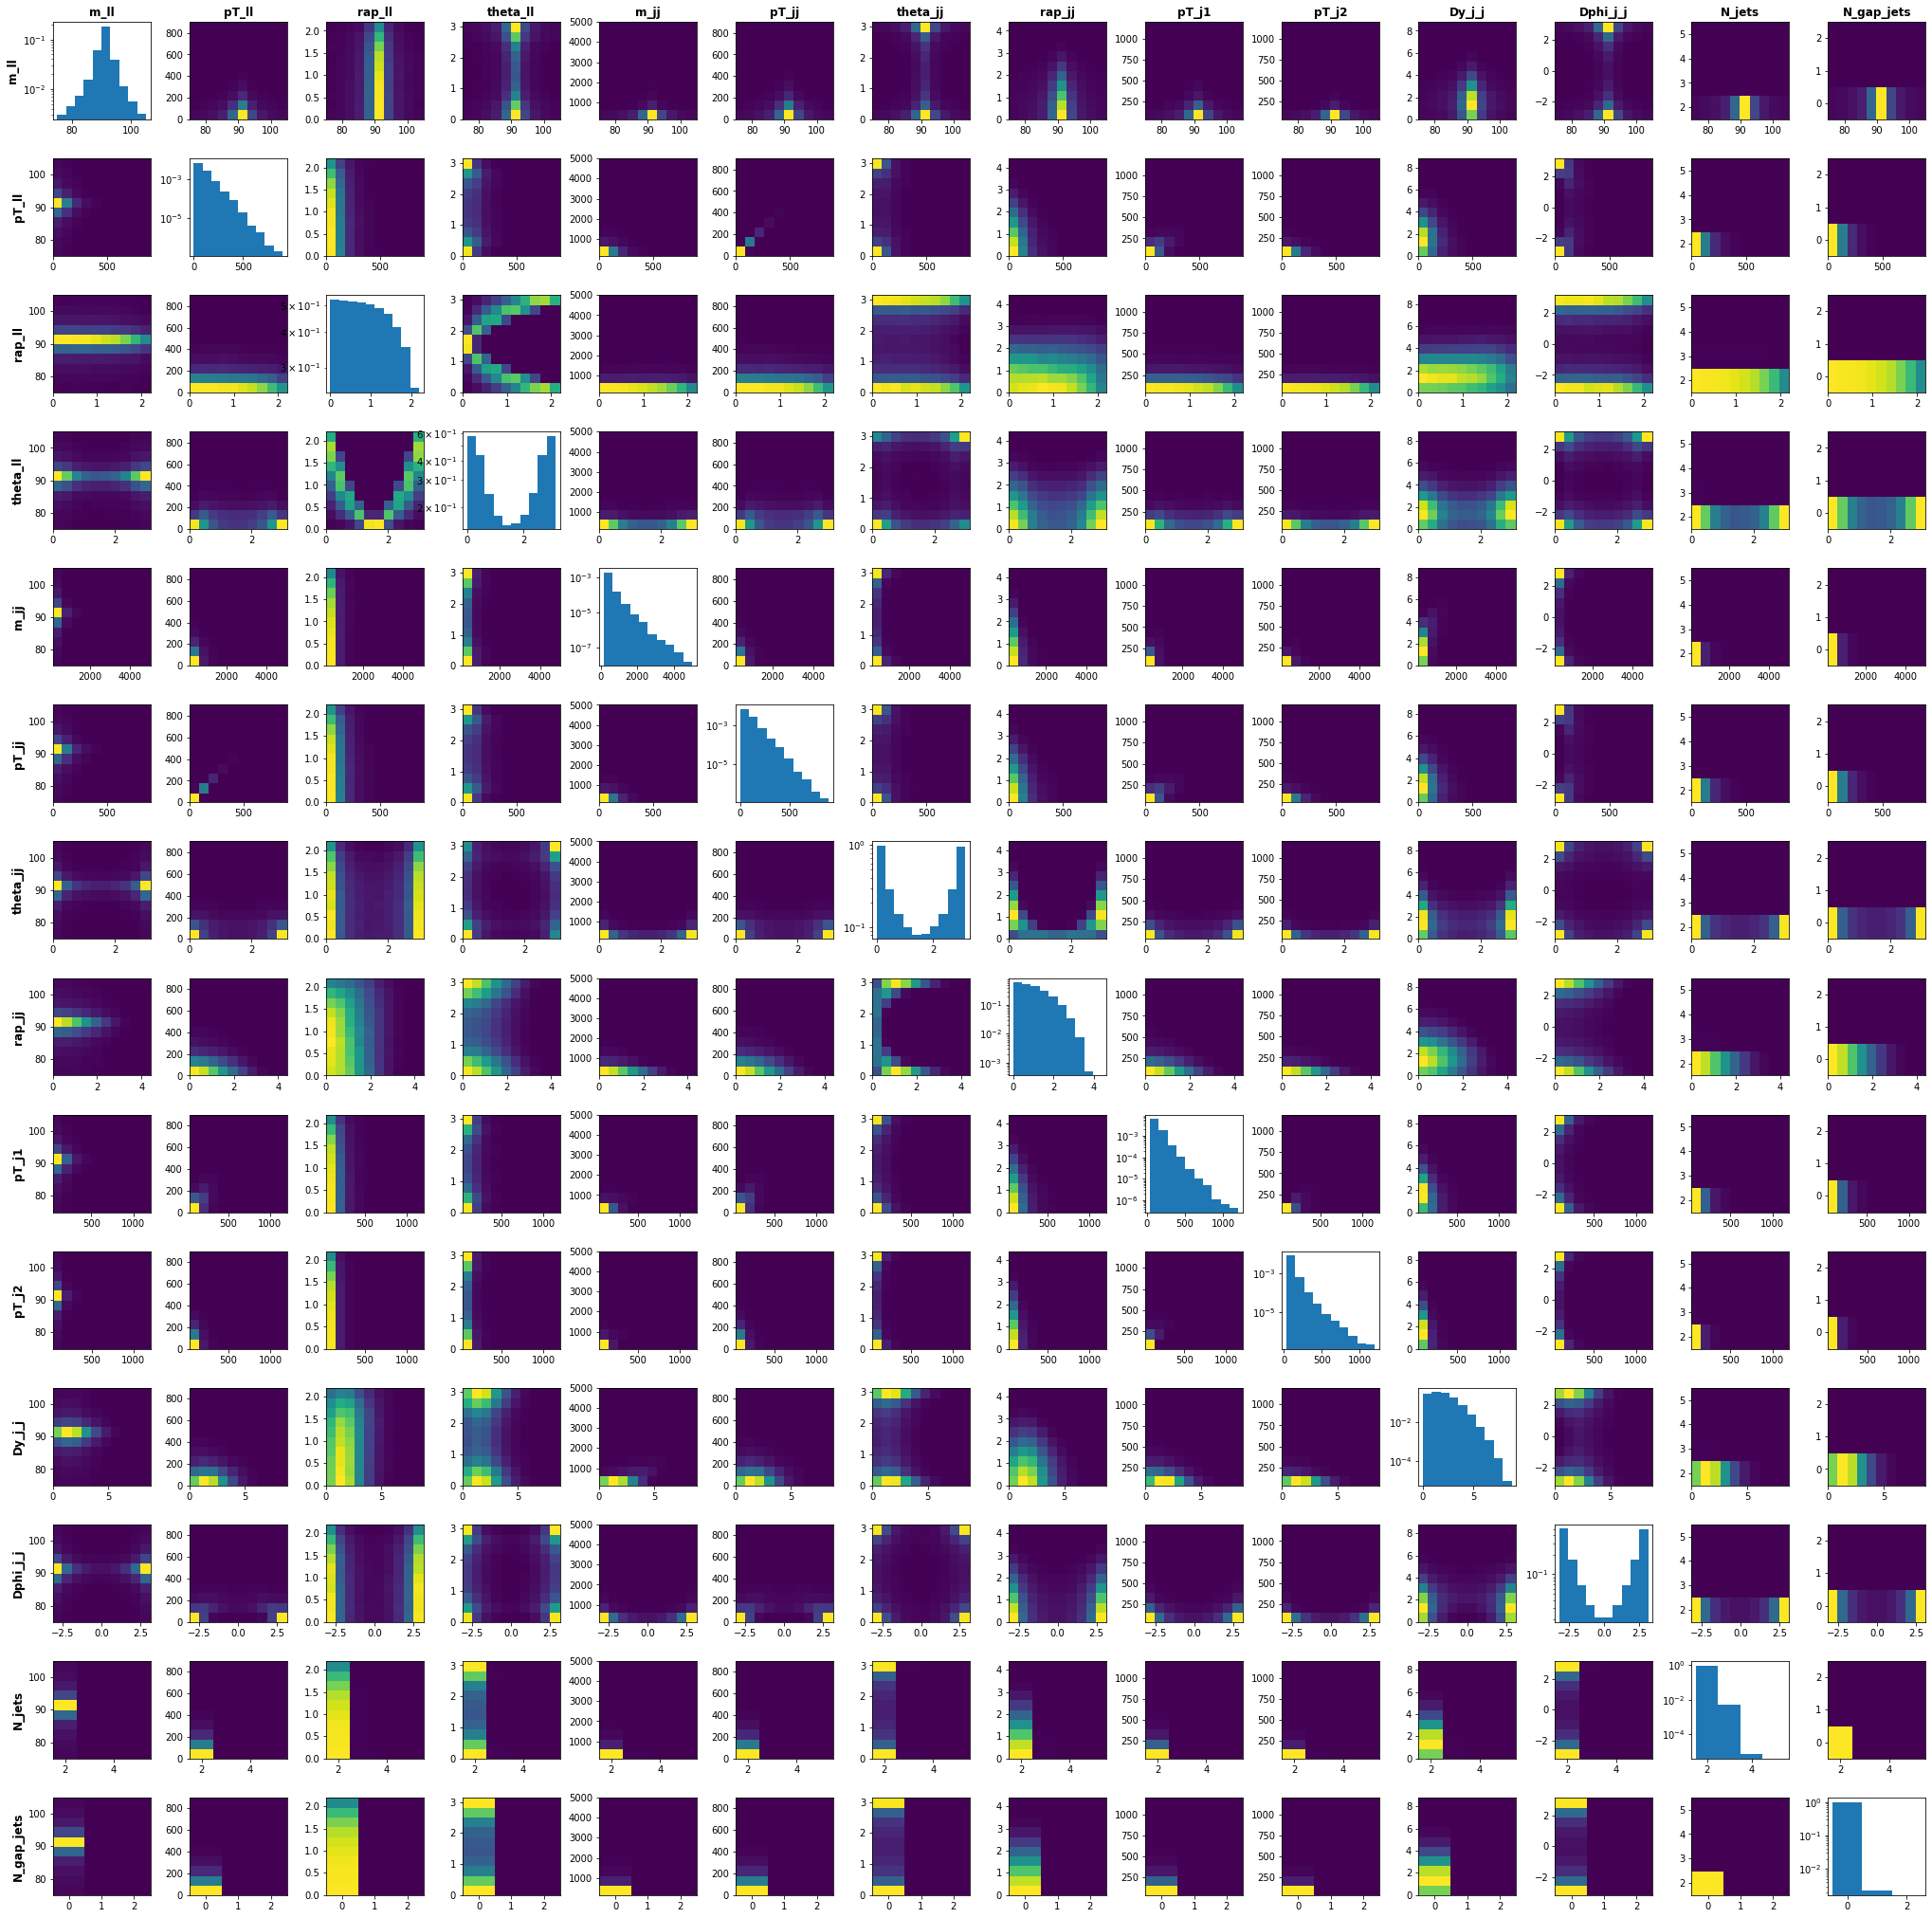

Filter efficiency is 100.000%


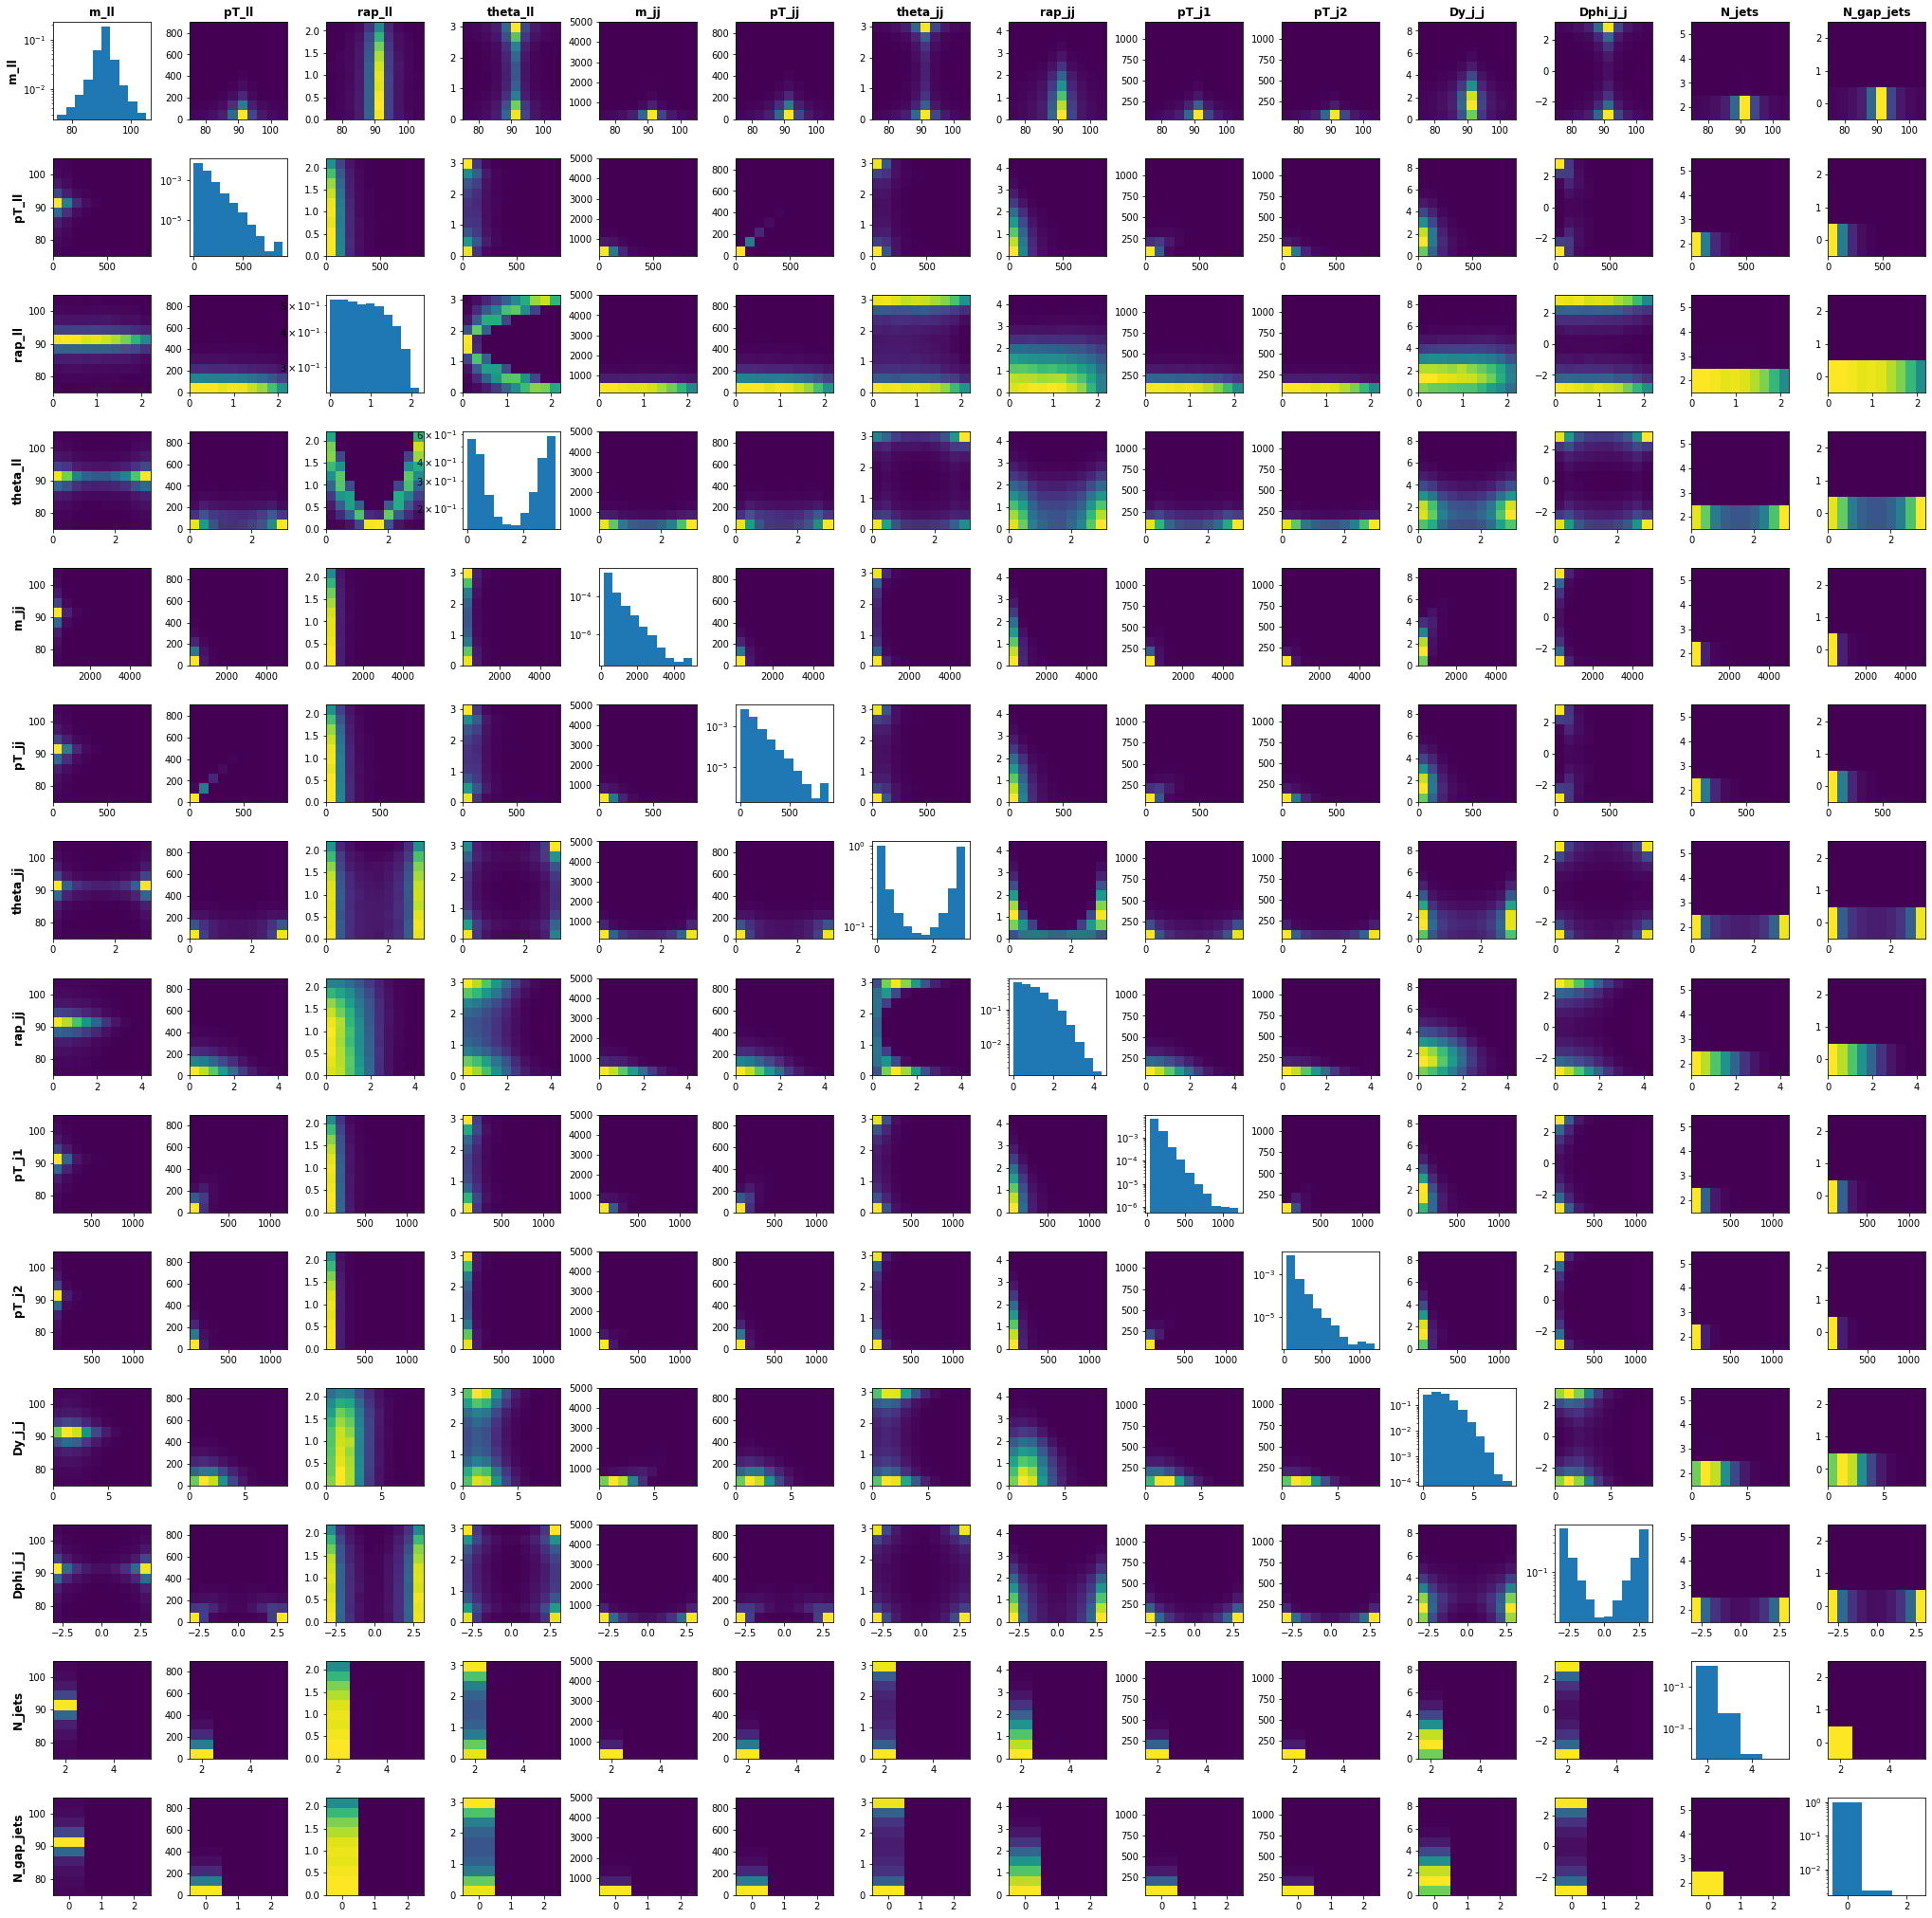

In [20]:
#  Plot original and generate data (total phase space)

plot_data(observable_data, weight_data, save="../figures/get_QCD_density2_true_fid.pdf", keys=data.keys, bins=10)
plot_data(fake_datapoints, save="../figures/get_QCD_density2_gen_fid.pdf", keys=data.keys, bins=10)

Filtering m_jj between 1000 and 5000
Filtering Dy_j_j between 2 and 8.8
Filter efficiency is 2.592%


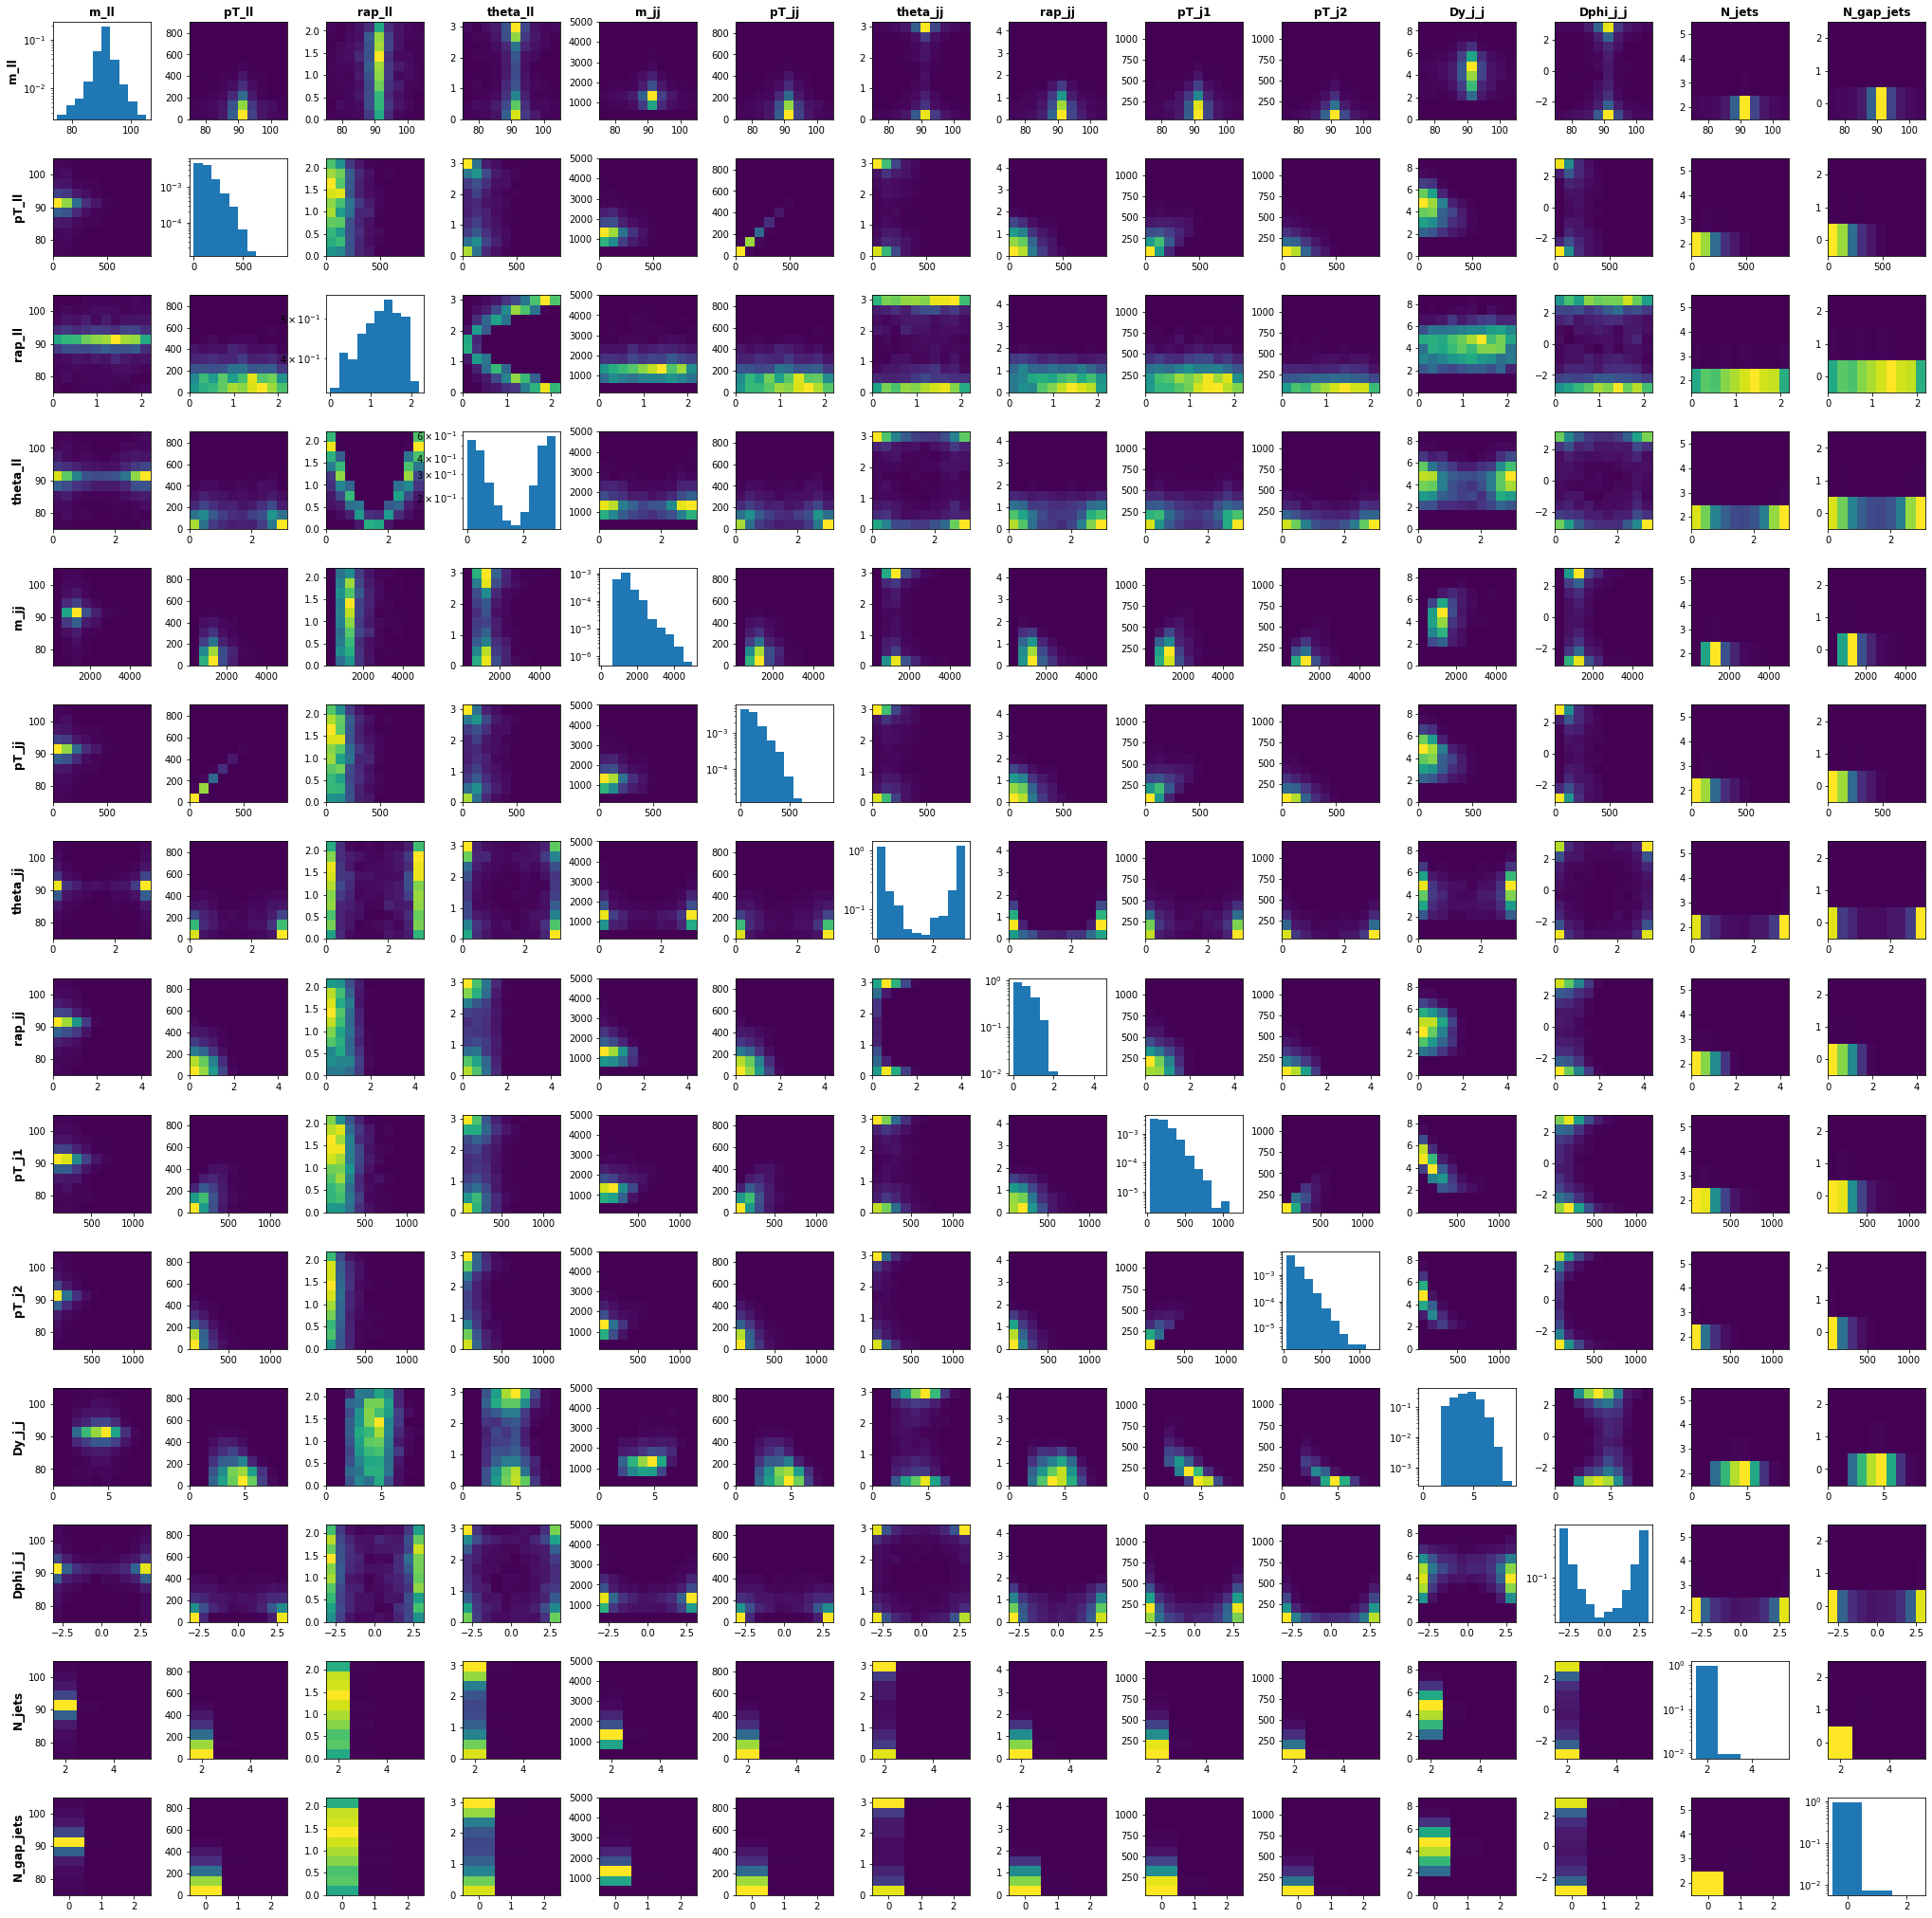

Filtering m_jj between 1000 and 5000
Filtering Dy_j_j between 2 and 8.8
Filter efficiency is 2.504%


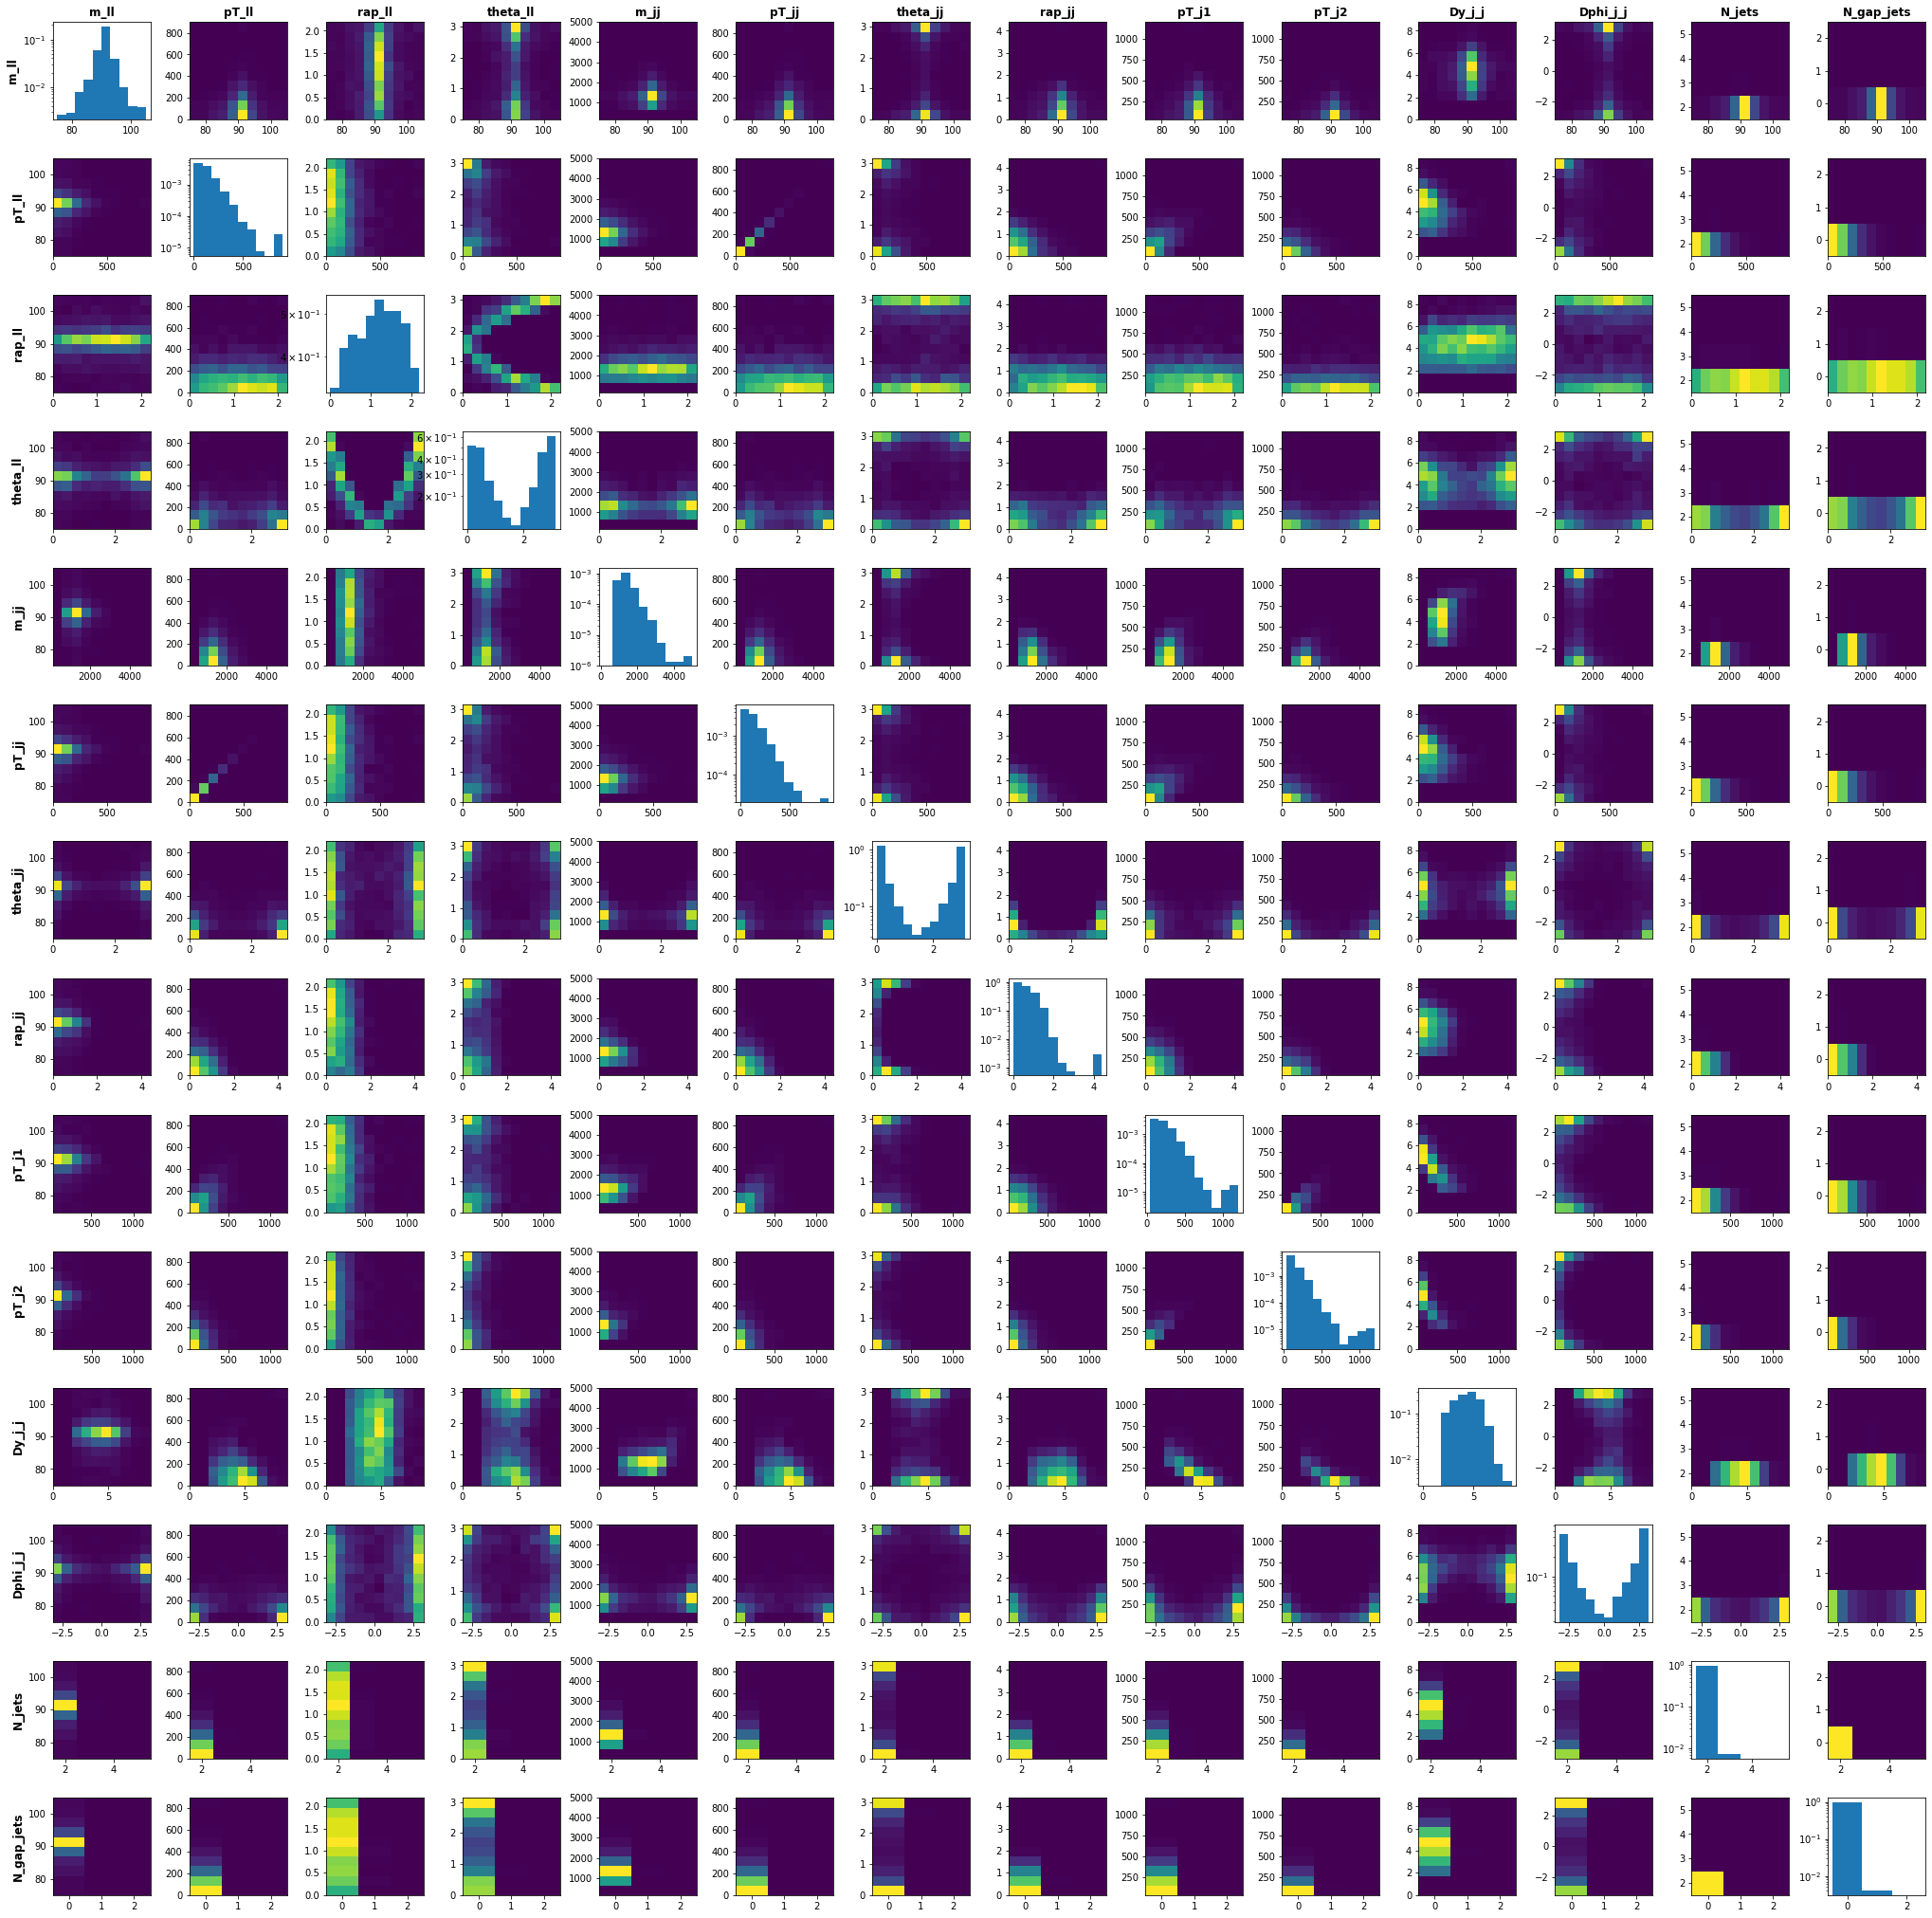

In [21]:
#  Plot data (VBF fiducial)

cuts = []
cuts.append(["m_jj"  , 1000, 5000])
cuts.append(["Dy_j_j", 2   , 8.8 ])

plot_data(observable_data, weight_data, cuts=cuts, keys=data.keys, save="../figures/get_QCD_density2_true_VBF_like.pdf", bins=10)
plot_data(fake_datapoints, cuts=cuts, keys=data.keys, save="../figures/get_QCD_density2_gen_VBF_like.pdf", bins=10)


Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2 = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: divide by zero encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value enco

/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2 = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2 = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: divide by zero enco

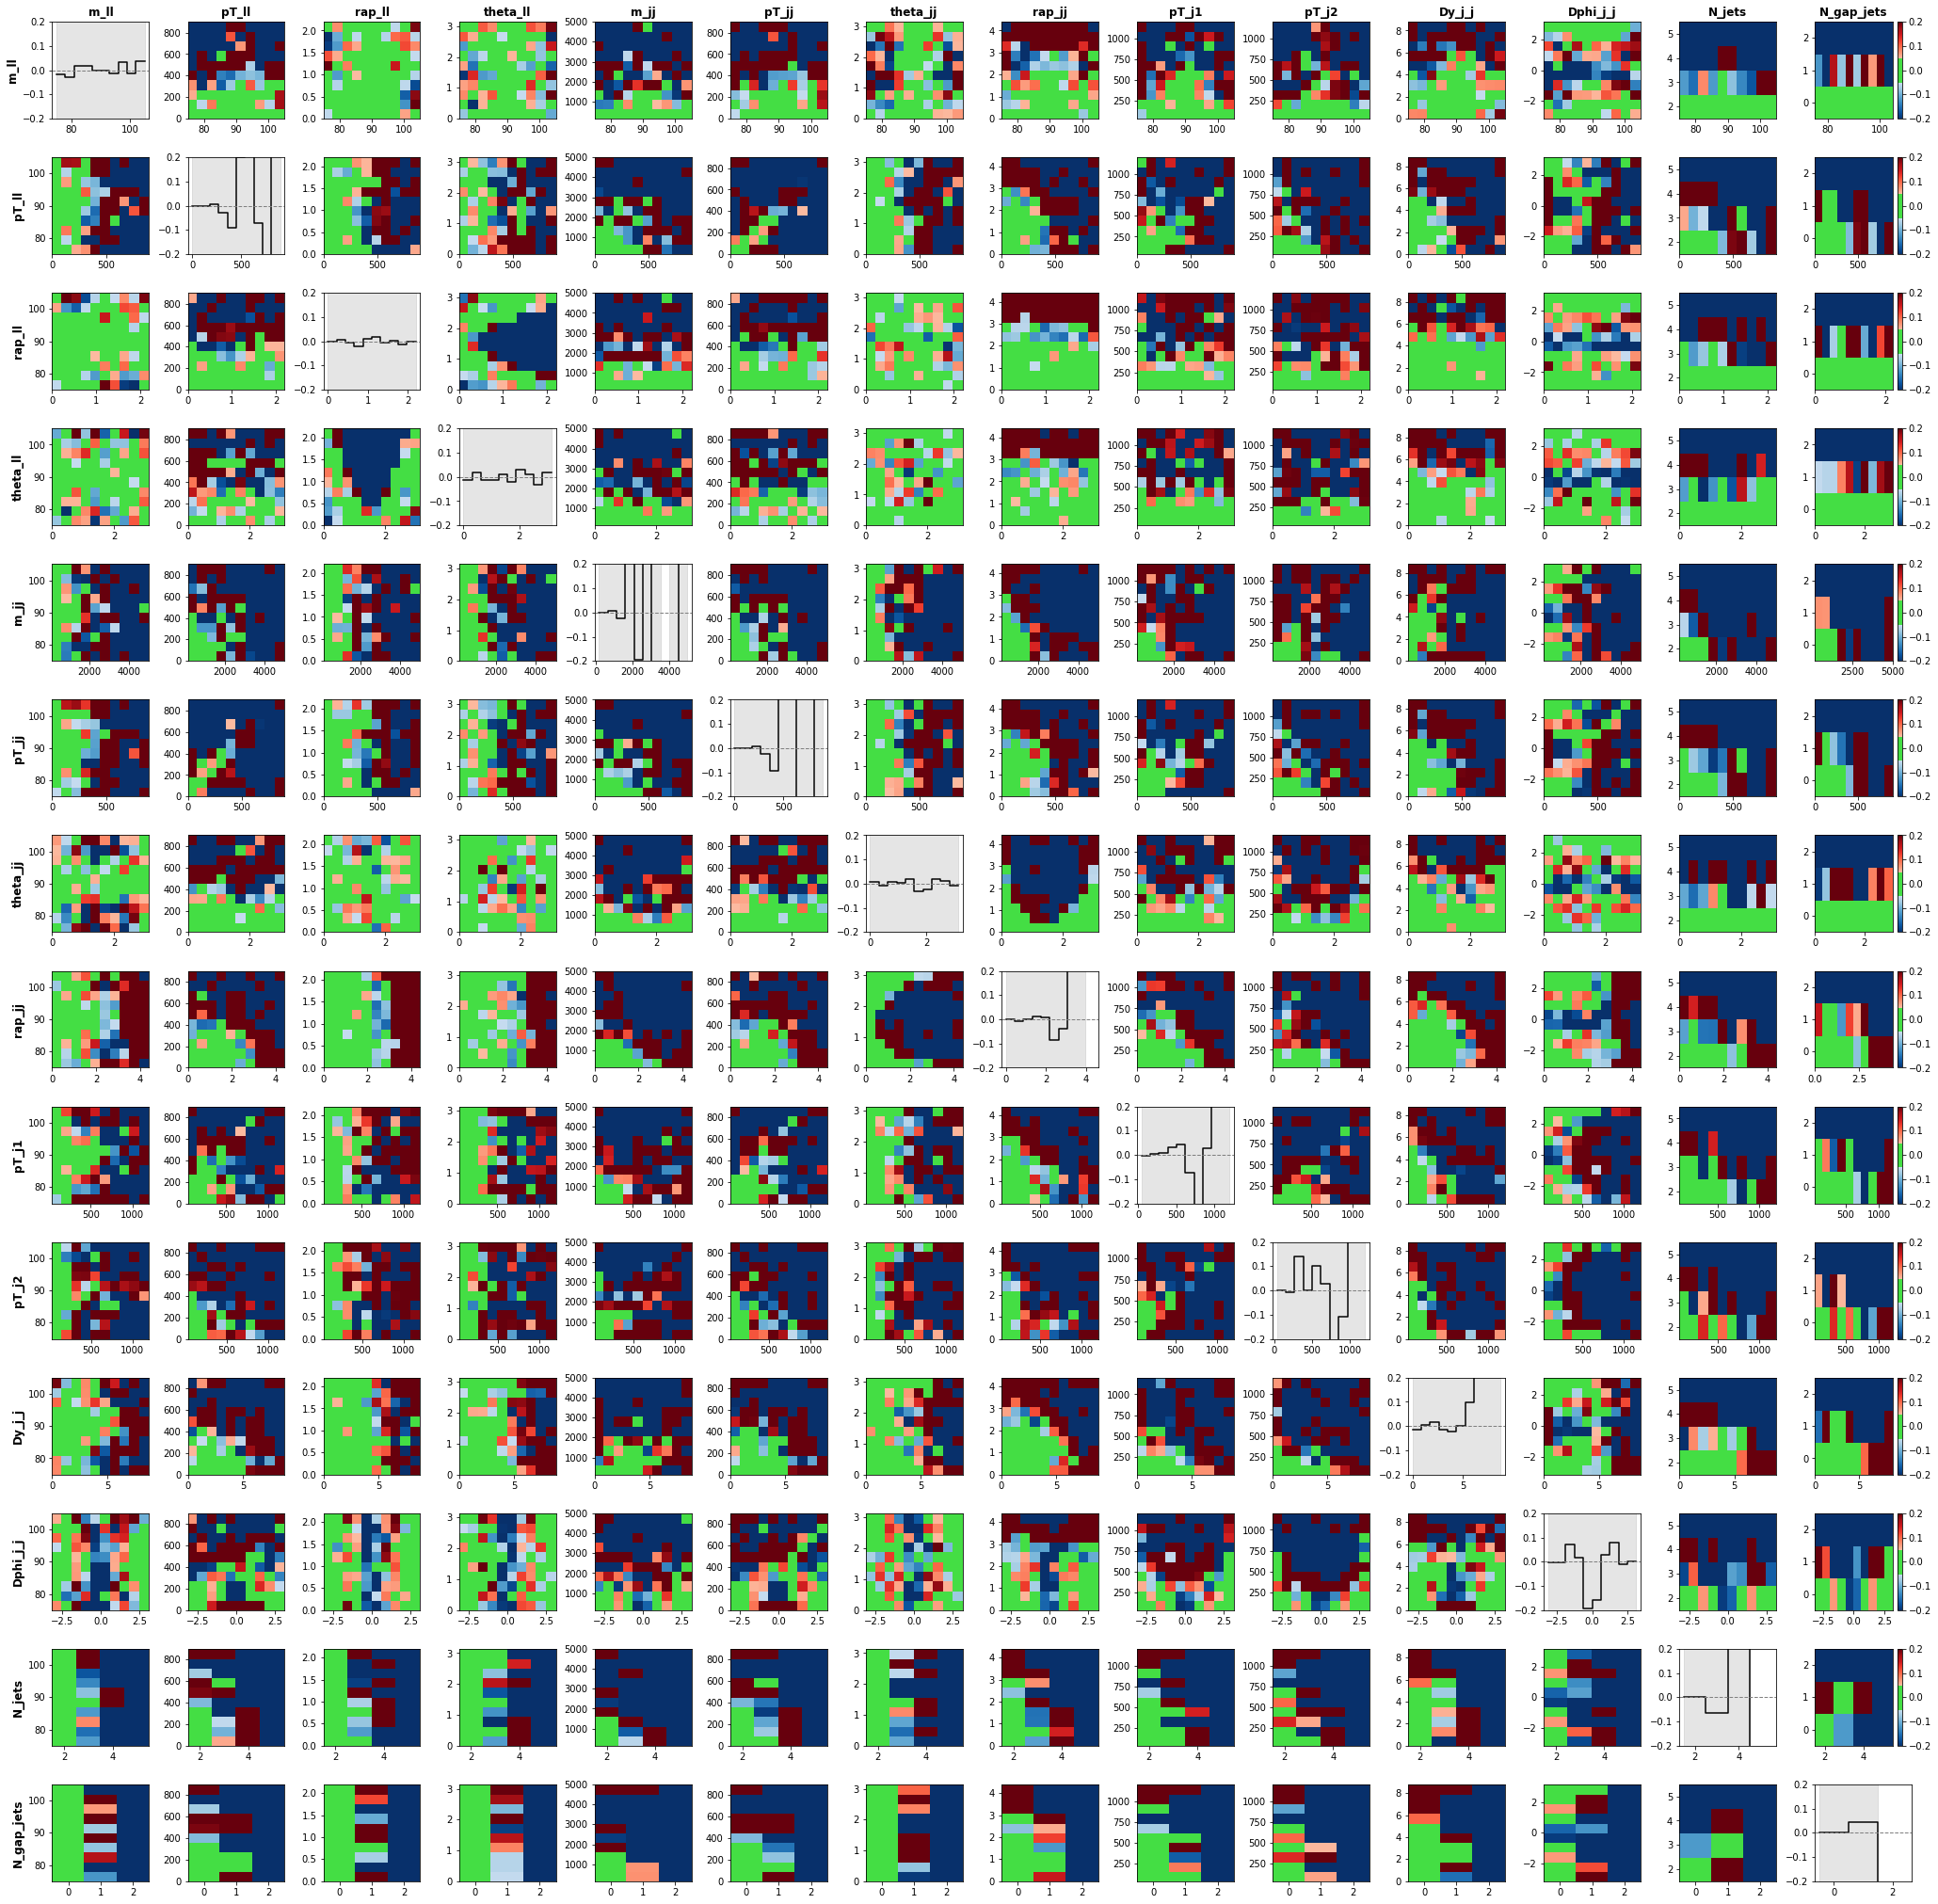

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:179: RuntimeWarning: invalid value encountered in true_divide
  return X, Y, num/den
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:179: RuntimeWarning: invalid value encountered in true_divide
  return X, Y, num/den
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:179: RuntimeWarning: invalid value encountered in true_divide
  return X, Y, num/den
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:179: RuntimeWarning: invalid value encountered in true_divide
  return X, Y, num/den
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:179: RuntimeWarning: invalid value encountered in true_divide
  return X, Y, num/den
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:179: RuntimeWarning: invalid value 

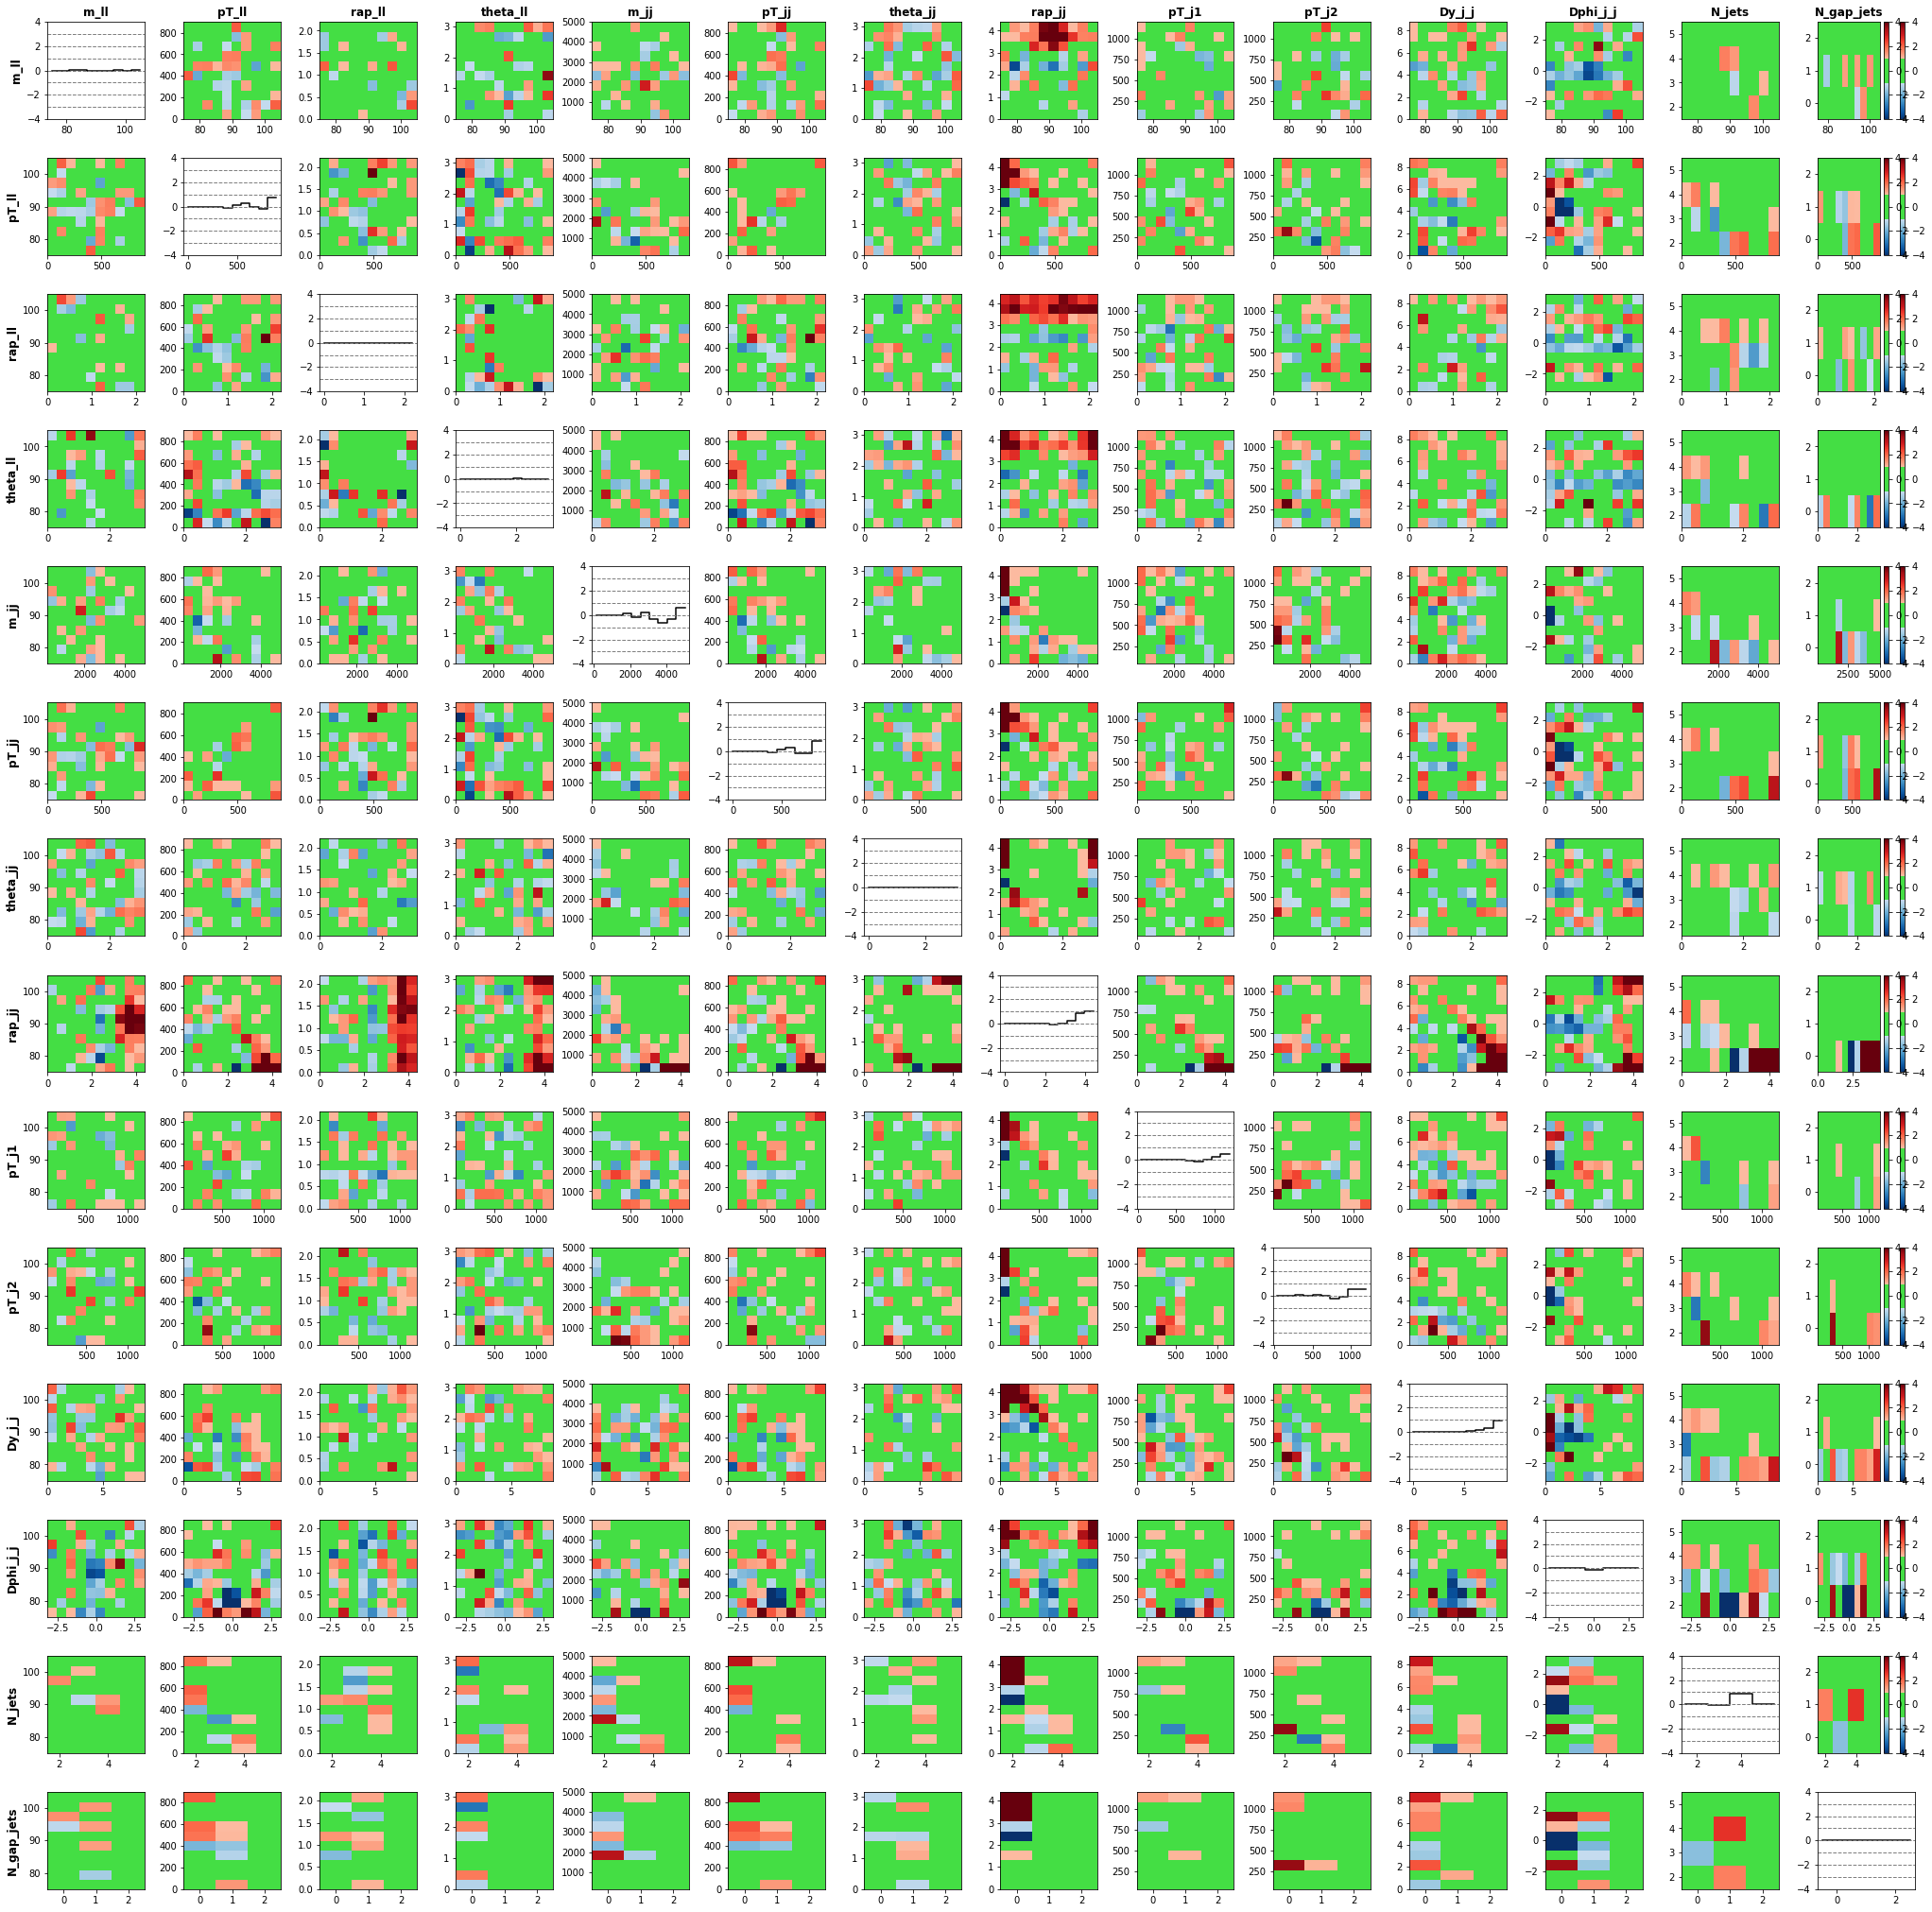

In [22]:
#  Plot ratio between original and generated data (total phase space)

plot_ratio(observable_data, fake_datapoints, weight_data, None, keys=data.keys, bins=10, save="../figures/get_QCD_density2_ratio_fid.pdf")

#  Plot pull between original and generated data (total phase space)

plot_pull(observable_data, fake_datapoints, weight_data, None, keys=data.keys, bins=10, save="../figures/get_QCD_density2_pull_fid.pdf")


Filtering m_jj between 1000 and 5000 (numerator)
Filtering Dy_j_j between 2 and 8.8 (numerator)
Numerator filter efficiency is 2.592%
Filtering m_jj between 1000 and 5000 (numerator)
Filtering Dy_j_j between 2 and 8.8 (numerator)
Denominator filter efficiency is 2.504%


/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2 = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: divide by zero encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value enco

/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2 = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: divide by zero encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value enco

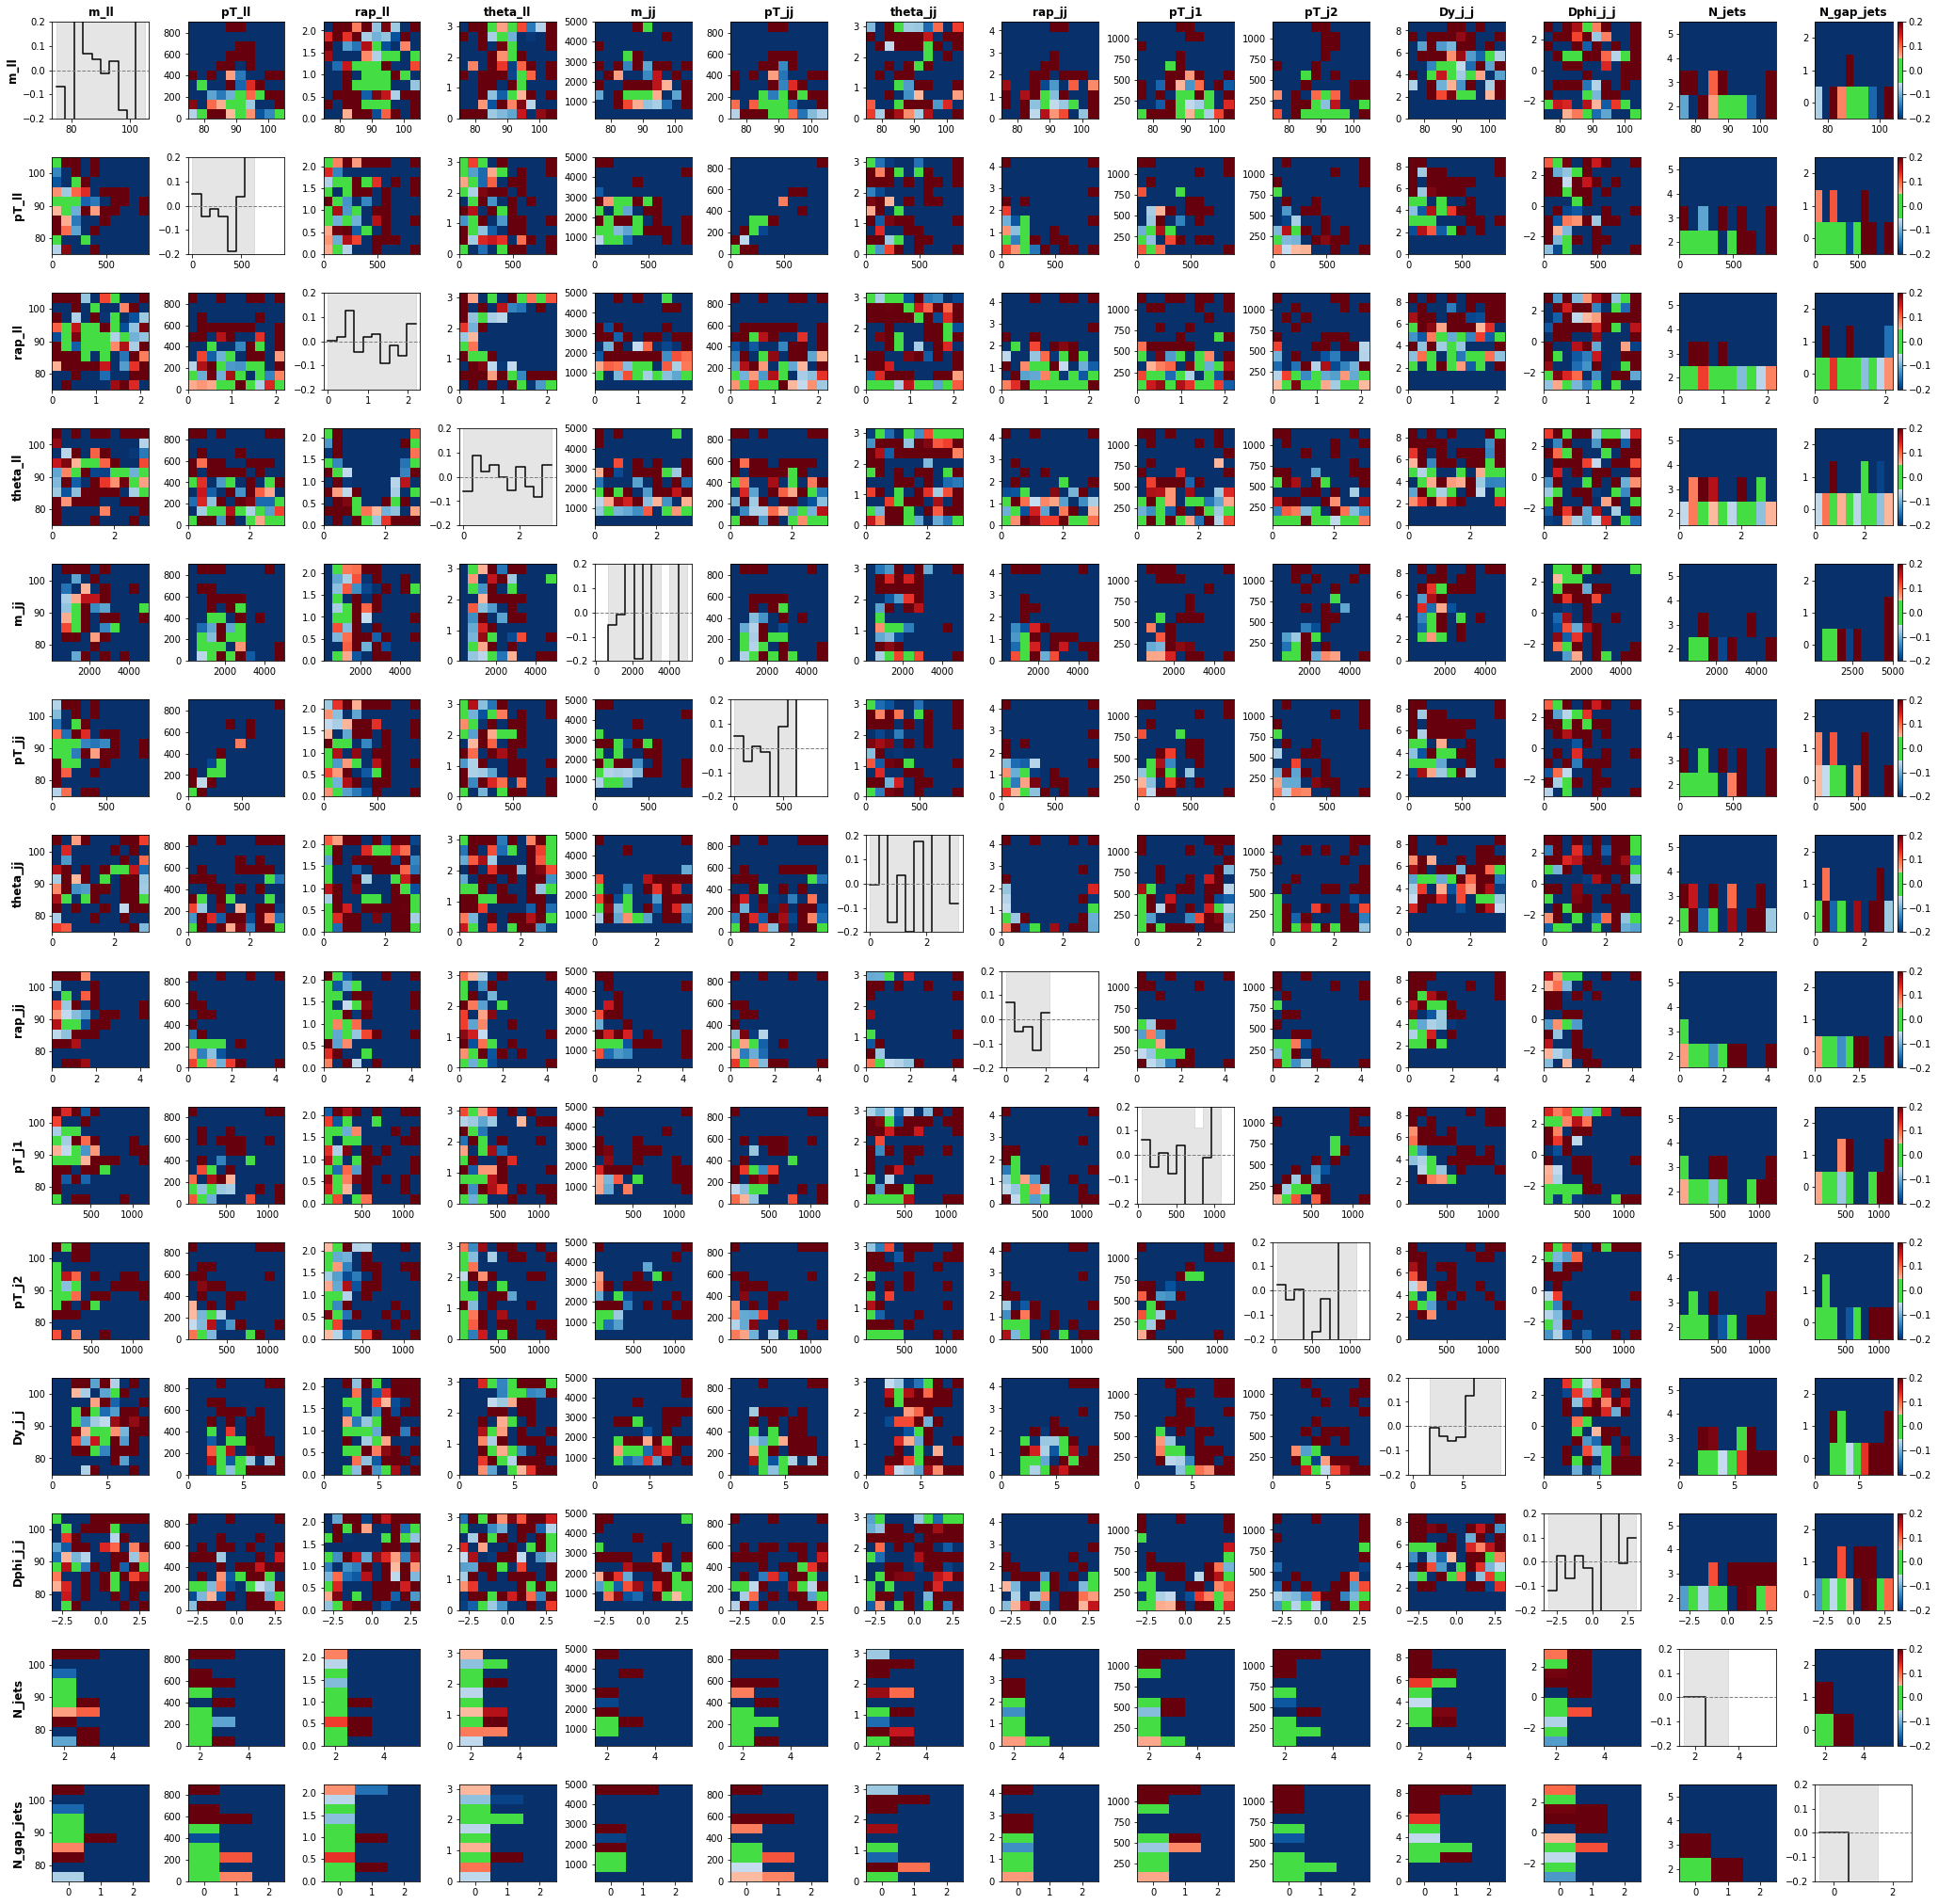

Filtering m_jj between 1000 and 5000 (numerator)
Filtering Dy_j_j between 2 and 8.8 (numerator)
Numerator filter efficiency is 2.592%
Filtering m_jj between 1000 and 5000 (numerator)
Filtering Dy_j_j between 2 and 8.8 (numerator)
Denominator filter efficiency is 2.504%


/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:179: RuntimeWarning: invalid value encountered in true_divide
  return X, Y, num/den
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:157: RuntimeWarning: invalid value encountered in true_divide
  return X, num/den
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:179: RuntimeWarning: invalid value encountered in true_divide
  return X, Y, num/den
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:179: RuntimeWarning: invalid value encountered in true_divide
  return X, Y, num/den
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:179: RuntimeWarning: invalid value encountered in true_divide
  return X, Y, num/den
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:157: RuntimeWarning: invalid value enc

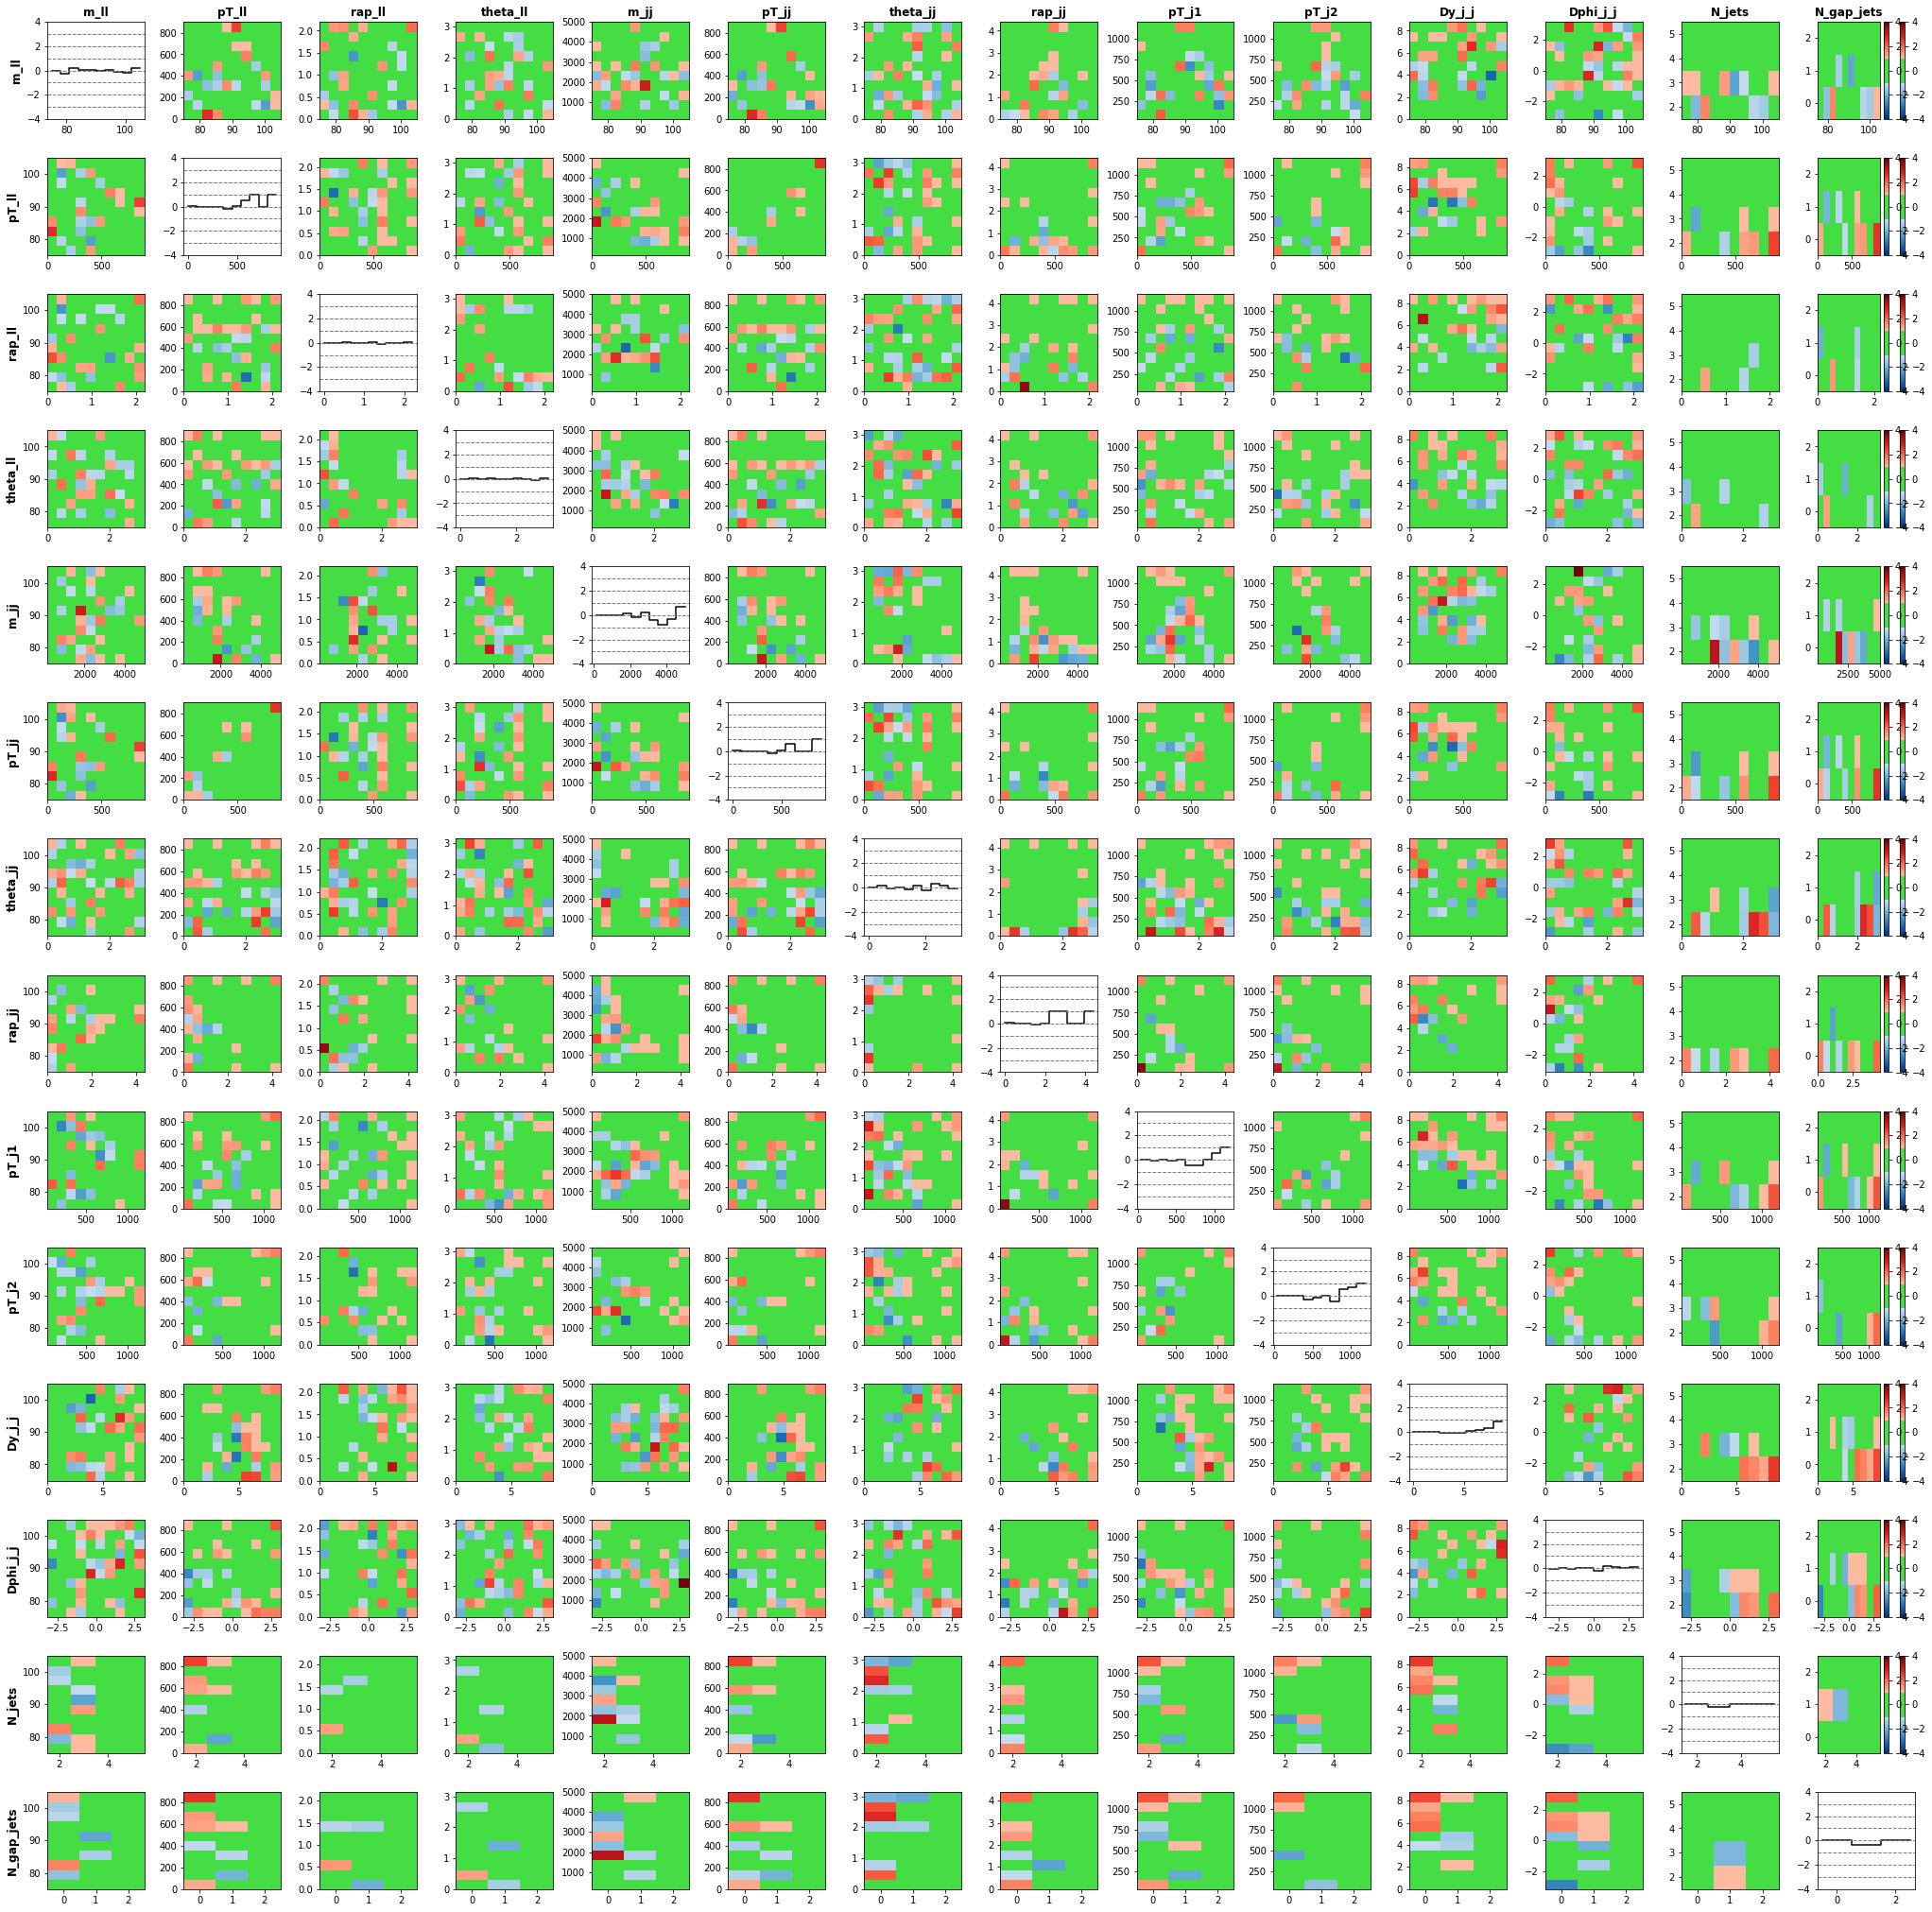

In [23]:
#  Plot ratio between original and generated data (VBF fiducial)

plot_ratio(observable_data, fake_datapoints, weight_data, None, keys=data.keys, bins=10, cuts=cuts, save="../figures/get_QCD_density2_ratio_fid.pdf")

#  Plot pull between original and generated data (VBF fiducial)

plot_pull(observable_data, fake_datapoints, weight_data, None, keys=data.keys, bins=10, cuts=cuts, save="../figures/get_QCD_density2_pull_fid.pdf")
